# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.03466423, -0.20955657,  0.04687366,  0.34162498]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.6762940010067853 -2.880725036697619


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    # loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
    #                                                               labels=tf.nn.sigmoid(Qs_labels)))    
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [15]:
# Training parameters
batch_size = 1000              # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
state, reward, action

(array([-8.28320869e-04,  5.90330441e-01, -1.11576881e-01, -1.12755225e+00]),
 1.0,
 1)

In [19]:
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        state = env.reset()
        total_reward = 0
        loss_batch = []

        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states}) 
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (0.99 * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episodes_total_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'explore_p:{:.4f}'.format(explore_p))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode:0 meanR:17.0000 loss:1.3251 explore_p:0.9983
Episode:1 meanR:19.0000 loss:2.2834 explore_p:0.9962
Episode:2 meanR:17.6667 loss:3.4505 explore_p:0.9948
Episode:3 meanR:19.2500 loss:6.1570 explore_p:0.9924
Episode:4 meanR:24.8000 loss:68.7073 explore_p:0.9878
Episode:5 meanR:23.6667 loss:347.5805 explore_p:0.9860
Episode:6 meanR:21.8571 loss:639.1490 explore_p:0.9850
Episode:7 meanR:26.3750 loss:533.3741 explore_p:0.9793
Episode:8 meanR:27.0000 loss:66.7435 explore_p:0.9762
Episode:9 meanR:25.2000 loss:47.1252 explore_p:0.9754
Episode:10 meanR:26.9091 loss:43.7758 explore_p:0.9711
Episode:11 meanR:27.0000 loss:47.4970 explore_p:0.9684
Episode:12 meanR:26.0000 loss:52.2377 explore_p:0.9671
Episode:13 meanR:25.5714 loss:54.6022 explore_p:0.9652
Episode:14 meanR:24.8667 loss:56.9052 explore_p:0.9638
Episode:15 meanR:24.3125 loss:59.8603 explore_p:0.9622
Episode:16 meanR:23.7059 loss:62.7379 explore_p:0.9609
Episode:17 meanR:23.6667 loss:67.8908 explore_p:0.9587
Episode:18 meanR:23.7

Episode:137 meanR:39.9400 loss:427907612672.0000 explore_p:0.6134
Episode:138 meanR:40.4200 loss:535009034240.0000 explore_p:0.6096
Episode:139 meanR:40.7500 loss:573563535360.0000 explore_p:0.6069
Episode:140 meanR:40.9300 loss:602375323648.0000 explore_p:0.6047
Episode:141 meanR:41.3100 loss:511473221632.0000 explore_p:0.6012
Episode:142 meanR:41.6700 loss:589898645504.0000 explore_p:0.5976
Episode:143 meanR:41.8100 loss:626501025792.0000 explore_p:0.5945
Episode:144 meanR:43.4500 loss:549120507904.0000 explore_p:0.5836
Episode:145 meanR:44.0300 loss:603626340352.0000 explore_p:0.5792
Episode:146 meanR:44.8000 loss:385159200768.0000 explore_p:0.5702
Episode:147 meanR:45.4400 loss:234915135488.0000 explore_p:0.5651
Episode:148 meanR:45.1500 loss:197459247104.0000 explore_p:0.5636
Episode:149 meanR:45.4900 loss:179704168448.0000 explore_p:0.5600
Episode:150 meanR:45.0300 loss:166114197504.0000 explore_p:0.5593
Episode:151 meanR:45.4100 loss:140949700608.0000 explore_p:0.5562
Episode:15

Episode:260 meanR:195.9300 loss:9250670641152.0000 explore_p:0.0806
Episode:261 meanR:197.7200 loss:9279679496192.0000 explore_p:0.0793
Episode:262 meanR:199.3600 loss:9284785012736.0000 explore_p:0.0779
Episode:263 meanR:199.1200 loss:9076744388608.0000 explore_p:0.0765
Episode:264 meanR:200.8200 loss:8848535453696.0000 explore_p:0.0753
Episode:265 meanR:201.2300 loss:8941834600448.0000 explore_p:0.0741
Episode:266 meanR:201.3400 loss:8870695010304.0000 explore_p:0.0727
Episode:267 meanR:201.2500 loss:8914982666240.0000 explore_p:0.0716
Episode:268 meanR:200.0300 loss:8957768761344.0000 explore_p:0.0704
Episode:269 meanR:200.7400 loss:8964662099968.0000 explore_p:0.0692
Episode:270 meanR:200.7800 loss:8793369346048.0000 explore_p:0.0680
Episode:271 meanR:200.5000 loss:8907036557312.0000 explore_p:0.0669
Episode:272 meanR:200.9100 loss:8945967038464.0000 explore_p:0.0658
Episode:273 meanR:202.5200 loss:8981446656000.0000 explore_p:0.0648
Episode:274 meanR:202.2300 loss:9076394164224.00

Episode:381 meanR:191.5200 loss:8568905400320.0000 explore_p:0.0169
Episode:382 meanR:191.4100 loss:8862344151040.0000 explore_p:0.0168
Episode:383 meanR:191.3400 loss:8971270225920.0000 explore_p:0.0166
Episode:384 meanR:191.3800 loss:8893848616960.0000 explore_p:0.0165
Episode:385 meanR:191.3200 loss:8934011174912.0000 explore_p:0.0164
Episode:386 meanR:191.0900 loss:9086927110144.0000 explore_p:0.0162
Episode:387 meanR:190.9200 loss:9184946946048.0000 explore_p:0.0161
Episode:388 meanR:190.7900 loss:9223121403904.0000 explore_p:0.0160
Episode:389 meanR:190.8600 loss:9360992370688.0000 explore_p:0.0159
Episode:390 meanR:190.6600 loss:9422147420160.0000 explore_p:0.0158
Episode:391 meanR:190.9400 loss:9282529525760.0000 explore_p:0.0157
Episode:392 meanR:190.9700 loss:9147973107712.0000 explore_p:0.0156
Episode:393 meanR:191.0900 loss:9039466463232.0000 explore_p:0.0155
Episode:394 meanR:191.4500 loss:8834571567104.0000 explore_p:0.0153
Episode:395 meanR:191.3700 loss:8872408383488.00

Episode:502 meanR:191.5100 loss:9318250315776.0000 explore_p:0.0107
Episode:503 meanR:191.3700 loss:9208925782016.0000 explore_p:0.0107
Episode:504 meanR:191.6000 loss:9242964656128.0000 explore_p:0.0107
Episode:505 meanR:191.2600 loss:9412776296448.0000 explore_p:0.0106
Episode:506 meanR:191.1900 loss:9372949282816.0000 explore_p:0.0106
Episode:507 meanR:191.4100 loss:9404943433728.0000 explore_p:0.0106
Episode:508 meanR:191.1700 loss:9546430939136.0000 explore_p:0.0106
Episode:509 meanR:191.1700 loss:9421291782144.0000 explore_p:0.0106
Episode:510 meanR:191.2100 loss:9476172152832.0000 explore_p:0.0106
Episode:511 meanR:191.3400 loss:9367064674304.0000 explore_p:0.0106
Episode:512 meanR:191.5500 loss:9169801314304.0000 explore_p:0.0106
Episode:513 meanR:191.3800 loss:9120174309376.0000 explore_p:0.0106
Episode:514 meanR:191.5500 loss:9034291740672.0000 explore_p:0.0105
Episode:515 meanR:191.5300 loss:8851408551936.0000 explore_p:0.0105
Episode:516 meanR:191.5900 loss:8962824994816.00

Episode:623 meanR:191.2100 loss:9347945988096.0000 explore_p:0.0101
Episode:624 meanR:191.3900 loss:9438707580928.0000 explore_p:0.0101
Episode:625 meanR:191.4200 loss:9348905435136.0000 explore_p:0.0101
Episode:626 meanR:191.4000 loss:9257536716800.0000 explore_p:0.0101
Episode:627 meanR:191.0300 loss:9378786705408.0000 explore_p:0.0101
Episode:628 meanR:190.7600 loss:9397003616256.0000 explore_p:0.0101
Episode:629 meanR:190.6000 loss:9403985035264.0000 explore_p:0.0101
Episode:630 meanR:190.6700 loss:9280436568064.0000 explore_p:0.0101
Episode:631 meanR:190.7500 loss:9220837605376.0000 explore_p:0.0101
Episode:632 meanR:190.7700 loss:9209777225728.0000 explore_p:0.0101
Episode:633 meanR:190.8100 loss:9060213587968.0000 explore_p:0.0101
Episode:634 meanR:190.8500 loss:8956346892288.0000 explore_p:0.0101
Episode:635 meanR:190.8300 loss:9072447324160.0000 explore_p:0.0101
Episode:636 meanR:190.6500 loss:9226313269248.0000 explore_p:0.0101
Episode:637 meanR:190.6900 loss:9230841020416.00

Episode:744 meanR:192.5200 loss:9235405471744.0000 explore_p:0.0100
Episode:745 meanR:192.3900 loss:9231020326912.0000 explore_p:0.0100
Episode:746 meanR:192.4700 loss:9307557986304.0000 explore_p:0.0100
Episode:747 meanR:192.3800 loss:9261077757952.0000 explore_p:0.0100
Episode:748 meanR:192.3800 loss:9241337266176.0000 explore_p:0.0100
Episode:749 meanR:192.5100 loss:9229355188224.0000 explore_p:0.0100
Episode:750 meanR:192.2700 loss:9316388044800.0000 explore_p:0.0100
Episode:751 meanR:192.0600 loss:9425076092928.0000 explore_p:0.0100
Episode:752 meanR:191.8300 loss:9508275355648.0000 explore_p:0.0100
Episode:753 meanR:191.7100 loss:9615061286912.0000 explore_p:0.0100
Episode:754 meanR:191.5600 loss:9585562746880.0000 explore_p:0.0100
Episode:755 meanR:191.3300 loss:9571994173440.0000 explore_p:0.0100
Episode:756 meanR:191.7200 loss:9244619309056.0000 explore_p:0.0100
Episode:757 meanR:191.9200 loss:8926800117760.0000 explore_p:0.0100
Episode:758 meanR:191.8100 loss:8965037490176.00

Episode:865 meanR:190.0400 loss:8984964628480.0000 explore_p:0.0100
Episode:866 meanR:189.9000 loss:9142580281344.0000 explore_p:0.0100
Episode:867 meanR:190.0300 loss:9291082760192.0000 explore_p:0.0100
Episode:868 meanR:190.0900 loss:9328081764352.0000 explore_p:0.0100
Episode:869 meanR:190.2600 loss:9375043289088.0000 explore_p:0.0100
Episode:870 meanR:190.3700 loss:9156319772672.0000 explore_p:0.0100
Episode:871 meanR:190.2000 loss:8907249418240.0000 explore_p:0.0100
Episode:872 meanR:190.1200 loss:8914496126976.0000 explore_p:0.0100
Episode:873 meanR:190.1700 loss:8973989183488.0000 explore_p:0.0100
Episode:874 meanR:190.2300 loss:9072077176832.0000 explore_p:0.0100
Episode:875 meanR:190.1100 loss:9225973530624.0000 explore_p:0.0100
Episode:876 meanR:190.0900 loss:9348546822144.0000 explore_p:0.0100
Episode:877 meanR:189.8500 loss:9429932048384.0000 explore_p:0.0100
Episode:878 meanR:189.5400 loss:9598339645440.0000 explore_p:0.0100
Episode:879 meanR:189.6100 loss:9688663982080.00

Episode:986 meanR:190.9600 loss:9747919011840.0000 explore_p:0.0100
Episode:987 meanR:190.9200 loss:9962372726784.0000 explore_p:0.0100
Episode:988 meanR:190.7300 loss:10072751079424.0000 explore_p:0.0100
Episode:989 meanR:190.6700 loss:10058612080640.0000 explore_p:0.0100
Episode:990 meanR:190.6300 loss:9949730045952.0000 explore_p:0.0100
Episode:991 meanR:190.3300 loss:9873081237504.0000 explore_p:0.0100
Episode:992 meanR:190.2700 loss:9839730229248.0000 explore_p:0.0100
Episode:993 meanR:190.2500 loss:9922159837184.0000 explore_p:0.0100
Episode:994 meanR:190.1000 loss:9985140457472.0000 explore_p:0.0100
Episode:995 meanR:190.2300 loss:10048343375872.0000 explore_p:0.0100
Episode:996 meanR:189.9300 loss:10247344226304.0000 explore_p:0.0100
Episode:997 meanR:189.7400 loss:10218497900544.0000 explore_p:0.0100
Episode:998 meanR:189.5600 loss:10190796619776.0000 explore_p:0.0100
Episode:999 meanR:189.6700 loss:10072942968832.0000 explore_p:0.0100
Episode:1000 meanR:189.4900 loss:10149395

Episode:1104 meanR:177.5700 loss:10217431498752.0000 explore_p:0.0100
Episode:1105 meanR:177.7000 loss:10307011346432.0000 explore_p:0.0100
Episode:1106 meanR:177.5800 loss:10193706418176.0000 explore_p:0.0100
Episode:1107 meanR:177.4400 loss:10215981318144.0000 explore_p:0.0100
Episode:1108 meanR:177.4800 loss:10095844917248.0000 explore_p:0.0100
Episode:1109 meanR:177.3700 loss:10115579117568.0000 explore_p:0.0100
Episode:1110 meanR:177.3300 loss:10054195478528.0000 explore_p:0.0100
Episode:1111 meanR:177.3300 loss:10302243471360.0000 explore_p:0.0100
Episode:1112 meanR:177.3100 loss:10298773733376.0000 explore_p:0.0100
Episode:1113 meanR:177.2800 loss:10250192158720.0000 explore_p:0.0100
Episode:1114 meanR:177.4600 loss:10321483792384.0000 explore_p:0.0100
Episode:1115 meanR:177.2700 loss:10327869620224.0000 explore_p:0.0100
Episode:1116 meanR:177.4200 loss:10238693474304.0000 explore_p:0.0100
Episode:1117 meanR:177.4400 loss:10142143741952.0000 explore_p:0.0100
Episode:1118 meanR:1

Episode:1222 meanR:179.4500 loss:10010046234624.0000 explore_p:0.0100
Episode:1223 meanR:179.5300 loss:10050053603328.0000 explore_p:0.0100
Episode:1224 meanR:179.6300 loss:10060124127232.0000 explore_p:0.0100
Episode:1225 meanR:179.8100 loss:9821538484224.0000 explore_p:0.0100
Episode:1226 meanR:179.7500 loss:9743214051328.0000 explore_p:0.0100
Episode:1227 meanR:180.0300 loss:9634538586112.0000 explore_p:0.0100
Episode:1228 meanR:179.9600 loss:9556720615424.0000 explore_p:0.0100
Episode:1229 meanR:179.7300 loss:9648033759232.0000 explore_p:0.0100
Episode:1230 meanR:179.6500 loss:9759411404800.0000 explore_p:0.0100
Episode:1231 meanR:179.5600 loss:10029105152000.0000 explore_p:0.0100
Episode:1232 meanR:179.6600 loss:10049425506304.0000 explore_p:0.0100
Episode:1233 meanR:179.5500 loss:10251830034432.0000 explore_p:0.0100
Episode:1234 meanR:179.5600 loss:10240433061888.0000 explore_p:0.0100
Episode:1235 meanR:179.7500 loss:10201361022976.0000 explore_p:0.0100
Episode:1236 meanR:179.560

Episode:1340 meanR:179.2500 loss:9896563048448.0000 explore_p:0.0100
Episode:1341 meanR:179.0900 loss:9955970121728.0000 explore_p:0.0100
Episode:1342 meanR:179.2200 loss:10163873382400.0000 explore_p:0.0100
Episode:1343 meanR:179.4200 loss:9962012016640.0000 explore_p:0.0100
Episode:1344 meanR:179.4100 loss:9880122425344.0000 explore_p:0.0100
Episode:1345 meanR:179.5500 loss:9749243363328.0000 explore_p:0.0100
Episode:1346 meanR:179.6700 loss:9755611365376.0000 explore_p:0.0100
Episode:1347 meanR:179.6900 loss:9620988887040.0000 explore_p:0.0100
Episode:1348 meanR:179.7600 loss:9644386811904.0000 explore_p:0.0100
Episode:1349 meanR:179.9600 loss:9738940055552.0000 explore_p:0.0100
Episode:1350 meanR:179.9600 loss:9734781403136.0000 explore_p:0.0100
Episode:1351 meanR:180.0400 loss:9802185965568.0000 explore_p:0.0100
Episode:1352 meanR:179.9300 loss:9940254064640.0000 explore_p:0.0100
Episode:1353 meanR:179.7900 loss:10054062309376.0000 explore_p:0.0100
Episode:1354 meanR:179.6500 loss

Episode:1458 meanR:178.1000 loss:10205719953408.0000 explore_p:0.0100
Episode:1459 meanR:178.0000 loss:10284538265600.0000 explore_p:0.0100
Episode:1460 meanR:177.9400 loss:10334195679232.0000 explore_p:0.0100
Episode:1461 meanR:178.0100 loss:10257576230912.0000 explore_p:0.0100
Episode:1462 meanR:178.0600 loss:10240272629760.0000 explore_p:0.0100
Episode:1463 meanR:178.0000 loss:10322749423616.0000 explore_p:0.0100
Episode:1464 meanR:177.8900 loss:10259767754752.0000 explore_p:0.0100
Episode:1465 meanR:178.0800 loss:10209400455168.0000 explore_p:0.0100
Episode:1466 meanR:178.1400 loss:10250711203840.0000 explore_p:0.0100
Episode:1467 meanR:178.0200 loss:10309842501632.0000 explore_p:0.0100
Episode:1468 meanR:178.0900 loss:10354837946368.0000 explore_p:0.0100
Episode:1469 meanR:178.1500 loss:10223738683392.0000 explore_p:0.0100
Episode:1470 meanR:178.1300 loss:10165768159232.0000 explore_p:0.0100
Episode:1471 meanR:178.1300 loss:10215014531072.0000 explore_p:0.0100
Episode:1472 meanR:1

Episode:1576 meanR:178.1800 loss:10121481551872.0000 explore_p:0.0100
Episode:1577 meanR:178.1500 loss:10127223554048.0000 explore_p:0.0100
Episode:1578 meanR:178.2000 loss:10056314650624.0000 explore_p:0.0100
Episode:1579 meanR:178.1500 loss:9997727563776.0000 explore_p:0.0100
Episode:1580 meanR:178.0400 loss:9987352952832.0000 explore_p:0.0100
Episode:1581 meanR:178.4100 loss:10025704620032.0000 explore_p:0.0100
Episode:1582 meanR:178.4600 loss:9916266840064.0000 explore_p:0.0100
Episode:1583 meanR:178.3700 loss:9945455001600.0000 explore_p:0.0100
Episode:1584 meanR:178.1700 loss:10126874378240.0000 explore_p:0.0100
Episode:1585 meanR:177.9900 loss:10321289805824.0000 explore_p:0.0100
Episode:1586 meanR:178.0900 loss:10190020673536.0000 explore_p:0.0100
Episode:1587 meanR:178.2500 loss:10221311229952.0000 explore_p:0.0100
Episode:1588 meanR:178.2700 loss:10153779789824.0000 explore_p:0.0100
Episode:1589 meanR:178.5300 loss:9865511567360.0000 explore_p:0.0100
Episode:1590 meanR:178.44

Episode:1694 meanR:179.3800 loss:9989726928896.0000 explore_p:0.0100
Episode:1695 meanR:179.5500 loss:9768161771520.0000 explore_p:0.0100
Episode:1696 meanR:179.4700 loss:9818277412864.0000 explore_p:0.0100
Episode:1697 meanR:179.5300 loss:9797550211072.0000 explore_p:0.0100
Episode:1698 meanR:179.6800 loss:9803058380800.0000 explore_p:0.0100
Episode:1699 meanR:179.7700 loss:9798614515712.0000 explore_p:0.0100
Episode:1700 meanR:179.6700 loss:10026928308224.0000 explore_p:0.0100
Episode:1701 meanR:179.8500 loss:10085832065024.0000 explore_p:0.0100
Episode:1702 meanR:179.8900 loss:10010381778944.0000 explore_p:0.0100
Episode:1703 meanR:179.9200 loss:9951990775808.0000 explore_p:0.0100
Episode:1704 meanR:179.8400 loss:10177102217216.0000 explore_p:0.0100
Episode:1705 meanR:179.7200 loss:10178214756352.0000 explore_p:0.0100
Episode:1706 meanR:179.6200 loss:10136899813376.0000 explore_p:0.0100
Episode:1707 meanR:179.7200 loss:10213287526400.0000 explore_p:0.0100
Episode:1708 meanR:179.4800

Episode:1812 meanR:179.8400 loss:10656426229760.0000 explore_p:0.0100
Episode:1813 meanR:179.7000 loss:10756573626368.0000 explore_p:0.0100
Episode:1814 meanR:179.7300 loss:10636600803328.0000 explore_p:0.0100
Episode:1815 meanR:179.5900 loss:10527178752000.0000 explore_p:0.0100
Episode:1816 meanR:179.6300 loss:10415931129856.0000 explore_p:0.0100
Episode:1817 meanR:179.5700 loss:10175200100352.0000 explore_p:0.0100
Episode:1818 meanR:179.4200 loss:10081651392512.0000 explore_p:0.0100
Episode:1819 meanR:179.3500 loss:10007965859840.0000 explore_p:0.0100
Episode:1820 meanR:179.4300 loss:10062038827008.0000 explore_p:0.0100
Episode:1821 meanR:179.4000 loss:9981861560320.0000 explore_p:0.0100
Episode:1822 meanR:179.4100 loss:10026304405504.0000 explore_p:0.0100
Episode:1823 meanR:179.3000 loss:10145996210176.0000 explore_p:0.0100
Episode:1824 meanR:179.2300 loss:10213696471040.0000 explore_p:0.0100
Episode:1825 meanR:179.2000 loss:10143744917504.0000 explore_p:0.0100
Episode:1826 meanR:17

Episode:1930 meanR:179.3700 loss:9879982964736.0000 explore_p:0.0100
Episode:1931 meanR:179.2200 loss:9995370364928.0000 explore_p:0.0100
Episode:1932 meanR:179.3200 loss:10148581998592.0000 explore_p:0.0100
Episode:1933 meanR:179.2000 loss:10231417405440.0000 explore_p:0.0100
Episode:1934 meanR:179.2700 loss:10379819220992.0000 explore_p:0.0100
Episode:1935 meanR:179.2300 loss:10478147338240.0000 explore_p:0.0100
Episode:1936 meanR:179.3400 loss:10419954515968.0000 explore_p:0.0100
Episode:1937 meanR:179.3700 loss:10329685753856.0000 explore_p:0.0100
Episode:1938 meanR:179.3200 loss:10305996324864.0000 explore_p:0.0100
Episode:1939 meanR:179.3500 loss:10143839289344.0000 explore_p:0.0100
Episode:1940 meanR:179.3600 loss:10132270350336.0000 explore_p:0.0100
Episode:1941 meanR:179.3100 loss:10084521345024.0000 explore_p:0.0100
Episode:1942 meanR:179.1300 loss:10137251086336.0000 explore_p:0.0100
Episode:1943 meanR:179.1600 loss:10184204222464.0000 explore_p:0.0100
Episode:1944 meanR:179

Episode:2048 meanR:177.7300 loss:9854738497536.0000 explore_p:0.0100
Episode:2049 meanR:177.4700 loss:9649147346944.0000 explore_p:0.0100
Episode:2050 meanR:177.6700 loss:9569864515584.0000 explore_p:0.0100
Episode:2051 meanR:177.6900 loss:9717792374784.0000 explore_p:0.0100
Episode:2052 meanR:177.6800 loss:9892231380992.0000 explore_p:0.0100
Episode:2053 meanR:177.7500 loss:9935002796032.0000 explore_p:0.0100
Episode:2054 meanR:177.6400 loss:10043691892736.0000 explore_p:0.0100
Episode:2055 meanR:177.7800 loss:9913271058432.0000 explore_p:0.0100
Episode:2056 meanR:177.7200 loss:9999746072576.0000 explore_p:0.0100
Episode:2057 meanR:177.7200 loss:9851776270336.0000 explore_p:0.0100
Episode:2058 meanR:177.7400 loss:9861192482816.0000 explore_p:0.0100
Episode:2059 meanR:178.0000 loss:9829397561344.0000 explore_p:0.0100
Episode:2060 meanR:177.9500 loss:9800587935744.0000 explore_p:0.0100
Episode:2061 meanR:177.7400 loss:9988679401472.0000 explore_p:0.0100
Episode:2062 meanR:177.7400 loss:

Episode:2166 meanR:178.9500 loss:10190792425472.0000 explore_p:0.0100
Episode:2167 meanR:179.0700 loss:10044573745152.0000 explore_p:0.0100
Episode:2168 meanR:178.7900 loss:10034163482624.0000 explore_p:0.0100
Episode:2169 meanR:178.8500 loss:9987693740032.0000 explore_p:0.0100
Episode:2170 meanR:179.1200 loss:9910012084224.0000 explore_p:0.0100
Episode:2171 meanR:179.4100 loss:9897050636288.0000 explore_p:0.0100
Episode:2172 meanR:179.4400 loss:9848152391680.0000 explore_p:0.0100
Episode:2173 meanR:179.2900 loss:9922961997824.0000 explore_p:0.0100
Episode:2174 meanR:179.2500 loss:9916790079488.0000 explore_p:0.0100
Episode:2175 meanR:179.1000 loss:10066404048896.0000 explore_p:0.0100
Episode:2176 meanR:178.9200 loss:10172849192960.0000 explore_p:0.0100
Episode:2177 meanR:178.9300 loss:10213491998720.0000 explore_p:0.0100
Episode:2178 meanR:178.9000 loss:10345842212864.0000 explore_p:0.0100
Episode:2179 meanR:179.0800 loss:10203784282112.0000 explore_p:0.0100
Episode:2180 meanR:178.870

Episode:2284 meanR:177.3400 loss:10262243442688.0000 explore_p:0.0100
Episode:2285 meanR:177.4900 loss:10353081581568.0000 explore_p:0.0100
Episode:2286 meanR:177.6600 loss:10112486866944.0000 explore_p:0.0100
Episode:2287 meanR:177.6800 loss:10123355357184.0000 explore_p:0.0100
Episode:2288 meanR:177.8000 loss:10071241129984.0000 explore_p:0.0100
Episode:2289 meanR:177.7900 loss:9916990357504.0000 explore_p:0.0100
Episode:2290 meanR:177.5800 loss:9992503558144.0000 explore_p:0.0100
Episode:2291 meanR:177.4700 loss:10128915955712.0000 explore_p:0.0100
Episode:2292 meanR:177.6300 loss:10274922823680.0000 explore_p:0.0100
Episode:2293 meanR:177.5800 loss:10232140922880.0000 explore_p:0.0100
Episode:2294 meanR:177.6800 loss:10227679232000.0000 explore_p:0.0100
Episode:2295 meanR:177.7200 loss:10189296107520.0000 explore_p:0.0100
Episode:2296 meanR:177.6800 loss:9969364631552.0000 explore_p:0.0100
Episode:2297 meanR:177.6400 loss:9855167365120.0000 explore_p:0.0100
Episode:2298 meanR:177.5

Episode:2402 meanR:177.7600 loss:10288759832576.0000 explore_p:0.0100
Episode:2403 meanR:177.6800 loss:10502210060288.0000 explore_p:0.0100
Episode:2404 meanR:177.8200 loss:10385603166208.0000 explore_p:0.0100
Episode:2405 meanR:178.0100 loss:10288093986816.0000 explore_p:0.0100
Episode:2406 meanR:177.9400 loss:10231607197696.0000 explore_p:0.0100
Episode:2407 meanR:178.2100 loss:10012904652800.0000 explore_p:0.0100
Episode:2408 meanR:178.3000 loss:9818720960512.0000 explore_p:0.0100
Episode:2409 meanR:178.2900 loss:9746014797824.0000 explore_p:0.0100
Episode:2410 meanR:178.4000 loss:9787953643520.0000 explore_p:0.0100
Episode:2411 meanR:178.3800 loss:9788640460800.0000 explore_p:0.0100
Episode:2412 meanR:178.5500 loss:9723934932992.0000 explore_p:0.0100
Episode:2413 meanR:178.5400 loss:9877541879808.0000 explore_p:0.0100
Episode:2414 meanR:178.4100 loss:10055167508480.0000 explore_p:0.0100
Episode:2415 meanR:178.3500 loss:10202131726336.0000 explore_p:0.0100
Episode:2416 meanR:178.340

Episode:2520 meanR:179.3100 loss:9914084753408.0000 explore_p:0.0100
Episode:2521 meanR:179.3100 loss:9821573087232.0000 explore_p:0.0100
Episode:2522 meanR:179.2600 loss:9878324117504.0000 explore_p:0.0100
Episode:2523 meanR:179.1100 loss:9860840161280.0000 explore_p:0.0100
Episode:2524 meanR:179.1400 loss:9862333333504.0000 explore_p:0.0100
Episode:2525 meanR:179.2500 loss:10052366761984.0000 explore_p:0.0100
Episode:2526 meanR:179.2500 loss:10062207647744.0000 explore_p:0.0100
Episode:2527 meanR:179.3300 loss:9944692686848.0000 explore_p:0.0100
Episode:2528 meanR:179.4300 loss:9942028255232.0000 explore_p:0.0100
Episode:2529 meanR:179.3300 loss:9801689989120.0000 explore_p:0.0100
Episode:2530 meanR:179.3700 loss:9747878117376.0000 explore_p:0.0100
Episode:2531 meanR:179.1900 loss:9736341684224.0000 explore_p:0.0100
Episode:2532 meanR:179.2100 loss:9755001094144.0000 explore_p:0.0100
Episode:2533 meanR:179.2000 loss:9832603058176.0000 explore_p:0.0100
Episode:2534 meanR:179.0200 loss

Episode:2638 meanR:178.2900 loss:10181670862848.0000 explore_p:0.0100
Episode:2639 meanR:178.4000 loss:10061727399936.0000 explore_p:0.0100
Episode:2640 meanR:178.5200 loss:9963274502144.0000 explore_p:0.0100
Episode:2641 meanR:178.6000 loss:9815835279360.0000 explore_p:0.0100
Episode:2642 meanR:178.4400 loss:9734273892352.0000 explore_p:0.0100
Episode:2643 meanR:178.4200 loss:9715810566144.0000 explore_p:0.0100
Episode:2644 meanR:178.5900 loss:9841667997696.0000 explore_p:0.0100
Episode:2645 meanR:178.8200 loss:9826941796352.0000 explore_p:0.0100
Episode:2646 meanR:178.6700 loss:9900742672384.0000 explore_p:0.0100
Episode:2647 meanR:178.7100 loss:10082827894784.0000 explore_p:0.0100
Episode:2648 meanR:178.5700 loss:10132480065536.0000 explore_p:0.0100
Episode:2649 meanR:178.6200 loss:10183937884160.0000 explore_p:0.0100
Episode:2650 meanR:178.4900 loss:10344204337152.0000 explore_p:0.0100
Episode:2651 meanR:178.3800 loss:10529042071552.0000 explore_p:0.0100
Episode:2652 meanR:178.3100

Episode:2756 meanR:179.1200 loss:10089507323904.0000 explore_p:0.0100
Episode:2757 meanR:179.1200 loss:10044284338176.0000 explore_p:0.0100
Episode:2758 meanR:179.0700 loss:10043567112192.0000 explore_p:0.0100
Episode:2759 meanR:179.1200 loss:10188805373952.0000 explore_p:0.0100
Episode:2760 meanR:179.2300 loss:10130521325568.0000 explore_p:0.0100
Episode:2761 meanR:179.1800 loss:10042675822592.0000 explore_p:0.0100
Episode:2762 meanR:179.1300 loss:9957329076224.0000 explore_p:0.0100
Episode:2763 meanR:179.2200 loss:9897681879040.0000 explore_p:0.0100
Episode:2764 meanR:179.2000 loss:9963327979520.0000 explore_p:0.0100
Episode:2765 meanR:178.9700 loss:10143173443584.0000 explore_p:0.0100
Episode:2766 meanR:178.8600 loss:10201276088320.0000 explore_p:0.0100
Episode:2767 meanR:178.8500 loss:10347975016448.0000 explore_p:0.0100
Episode:2768 meanR:178.6400 loss:10550784294912.0000 explore_p:0.0100
Episode:2769 meanR:178.6300 loss:10585062244352.0000 explore_p:0.0100
Episode:2770 meanR:178.

Episode:2874 meanR:178.5200 loss:9966253506560.0000 explore_p:0.0100
Episode:2875 meanR:178.5200 loss:10012098297856.0000 explore_p:0.0100
Episode:2876 meanR:178.6200 loss:10051716644864.0000 explore_p:0.0100
Episode:2877 meanR:178.7000 loss:10083660464128.0000 explore_p:0.0100
Episode:2878 meanR:178.3900 loss:10195904233472.0000 explore_p:0.0100
Episode:2879 meanR:178.4400 loss:10165511258112.0000 explore_p:0.0100
Episode:2880 meanR:178.3900 loss:10038395535360.0000 explore_p:0.0100
Episode:2881 meanR:178.3300 loss:10080728645632.0000 explore_p:0.0100
Episode:2882 meanR:178.4700 loss:10015764119552.0000 explore_p:0.0100
Episode:2883 meanR:178.4800 loss:10073611960320.0000 explore_p:0.0100
Episode:2884 meanR:178.2800 loss:10111178244096.0000 explore_p:0.0100
Episode:2885 meanR:178.5000 loss:10163601801216.0000 explore_p:0.0100
Episode:2886 meanR:178.2400 loss:10176166887424.0000 explore_p:0.0100
Episode:2887 meanR:178.1600 loss:10176565346304.0000 explore_p:0.0100
Episode:2888 meanR:17

Episode:2992 meanR:177.5000 loss:10294765027328.0000 explore_p:0.0100
Episode:2993 meanR:177.5700 loss:10235418771456.0000 explore_p:0.0100
Episode:2994 meanR:177.3700 loss:10373804589056.0000 explore_p:0.0100
Episode:2995 meanR:177.5300 loss:10315736547328.0000 explore_p:0.0100
Episode:2996 meanR:177.4100 loss:10290529828864.0000 explore_p:0.0100
Episode:2997 meanR:177.5400 loss:10296531877888.0000 explore_p:0.0100
Episode:2998 meanR:177.6100 loss:10257097031680.0000 explore_p:0.0100
Episode:2999 meanR:177.8500 loss:10154513793024.0000 explore_p:0.0100
Episode:3000 meanR:177.9800 loss:9997013483520.0000 explore_p:0.0100
Episode:3001 meanR:178.1300 loss:9917637328896.0000 explore_p:0.0100
Episode:3002 meanR:178.0800 loss:9790687281152.0000 explore_p:0.0100
Episode:3003 meanR:178.2300 loss:9723185201152.0000 explore_p:0.0100
Episode:3004 meanR:178.3400 loss:9701892816896.0000 explore_p:0.0100
Episode:3005 meanR:178.1900 loss:9903241428992.0000 explore_p:0.0100
Episode:3006 meanR:178.230

Episode:3110 meanR:178.1800 loss:9949001285632.0000 explore_p:0.0100
Episode:3111 meanR:178.0600 loss:9969870045184.0000 explore_p:0.0100
Episode:3112 meanR:178.0900 loss:10080741228544.0000 explore_p:0.0100
Episode:3113 meanR:178.2600 loss:10080735985664.0000 explore_p:0.0100
Episode:3114 meanR:178.4100 loss:10015030116352.0000 explore_p:0.0100
Episode:3115 meanR:178.1900 loss:9973680570368.0000 explore_p:0.0100
Episode:3116 meanR:178.2800 loss:10079915999232.0000 explore_p:0.0100
Episode:3117 meanR:178.2600 loss:10018208350208.0000 explore_p:0.0100
Episode:3118 meanR:178.2100 loss:10014511071232.0000 explore_p:0.0100
Episode:3119 meanR:178.2700 loss:10102015787008.0000 explore_p:0.0100
Episode:3120 meanR:178.2100 loss:10317364985856.0000 explore_p:0.0100
Episode:3121 meanR:178.2300 loss:10143713460224.0000 explore_p:0.0100
Episode:3122 meanR:178.3800 loss:10106773176320.0000 explore_p:0.0100
Episode:3123 meanR:178.4500 loss:9981853171712.0000 explore_p:0.0100
Episode:3124 meanR:178.3

Episode:3228 meanR:178.9600 loss:10054091669504.0000 explore_p:0.0100
Episode:3229 meanR:178.8000 loss:10238908432384.0000 explore_p:0.0100
Episode:3230 meanR:179.0300 loss:10180052910080.0000 explore_p:0.0100
Episode:3231 meanR:178.9400 loss:10188491849728.0000 explore_p:0.0100
Episode:3232 meanR:179.0700 loss:10167221485568.0000 explore_p:0.0100
Episode:3233 meanR:179.3000 loss:10021565890560.0000 explore_p:0.0100
Episode:3234 meanR:179.4000 loss:9828743249920.0000 explore_p:0.0100
Episode:3235 meanR:179.5700 loss:9736050180096.0000 explore_p:0.0100
Episode:3236 meanR:179.6300 loss:9858973696000.0000 explore_p:0.0100
Episode:3237 meanR:179.4500 loss:9889844822016.0000 explore_p:0.0100
Episode:3238 meanR:179.5900 loss:9904051978240.0000 explore_p:0.0100
Episode:3239 meanR:179.5700 loss:10010599882752.0000 explore_p:0.0100
Episode:3240 meanR:179.7500 loss:10069568651264.0000 explore_p:0.0100
Episode:3241 meanR:179.6400 loss:10093505544192.0000 explore_p:0.0100
Episode:3242 meanR:179.75

Episode:3346 meanR:180.2800 loss:10345786638336.0000 explore_p:0.0100
Episode:3347 meanR:180.3500 loss:10205572104192.0000 explore_p:0.0100
Episode:3348 meanR:180.3000 loss:10191355510784.0000 explore_p:0.0100
Episode:3349 meanR:180.1700 loss:10264361566208.0000 explore_p:0.0100
Episode:3350 meanR:180.4000 loss:10289134174208.0000 explore_p:0.0100
Episode:3351 meanR:180.4700 loss:10202240778240.0000 explore_p:0.0100
Episode:3352 meanR:180.5700 loss:10094885470208.0000 explore_p:0.0100
Episode:3353 meanR:180.3600 loss:10097328652288.0000 explore_p:0.0100
Episode:3354 meanR:180.2400 loss:10245898240000.0000 explore_p:0.0100
Episode:3355 meanR:179.9200 loss:10376292859904.0000 explore_p:0.0100
Episode:3356 meanR:179.8200 loss:10478040383488.0000 explore_p:0.0100
Episode:3357 meanR:179.7000 loss:10492529606656.0000 explore_p:0.0100
Episode:3358 meanR:179.5600 loss:10568887959552.0000 explore_p:0.0100
Episode:3359 meanR:179.3700 loss:10573468139520.0000 explore_p:0.0100
Episode:3360 meanR:1

Episode:3464 meanR:177.4200 loss:10249335472128.0000 explore_p:0.0100
Episode:3465 meanR:177.6100 loss:10063155560448.0000 explore_p:0.0100
Episode:3466 meanR:177.8400 loss:9770193911808.0000 explore_p:0.0100
Episode:3467 meanR:177.6300 loss:9746985779200.0000 explore_p:0.0100
Episode:3468 meanR:177.8200 loss:9667968237568.0000 explore_p:0.0100
Episode:3469 meanR:177.9000 loss:9664073826304.0000 explore_p:0.0100
Episode:3470 meanR:178.0700 loss:9720906645504.0000 explore_p:0.0100
Episode:3471 meanR:178.2300 loss:9766858391552.0000 explore_p:0.0100
Episode:3472 meanR:178.2200 loss:9947464073216.0000 explore_p:0.0100
Episode:3473 meanR:178.2300 loss:9876000473088.0000 explore_p:0.0100
Episode:3474 meanR:178.4600 loss:9857959723008.0000 explore_p:0.0100
Episode:3475 meanR:178.2700 loss:9855942262784.0000 explore_p:0.0100
Episode:3476 meanR:178.3800 loss:9961985802240.0000 explore_p:0.0100
Episode:3477 meanR:178.4000 loss:9997079543808.0000 explore_p:0.0100
Episode:3478 meanR:178.3000 loss

Episode:3582 meanR:179.6800 loss:9949434347520.0000 explore_p:0.0100
Episode:3583 meanR:179.6900 loss:10005398945792.0000 explore_p:0.0100
Episode:3584 meanR:179.5200 loss:10004792868864.0000 explore_p:0.0100
Episode:3585 meanR:179.5100 loss:10046994907136.0000 explore_p:0.0100
Episode:3586 meanR:179.6000 loss:9942262087680.0000 explore_p:0.0100
Episode:3587 meanR:179.5100 loss:10033908678656.0000 explore_p:0.0100
Episode:3588 meanR:179.5600 loss:10272672579584.0000 explore_p:0.0100
Episode:3589 meanR:179.6200 loss:10240532676608.0000 explore_p:0.0100
Episode:3590 meanR:179.8100 loss:10267063746560.0000 explore_p:0.0100
Episode:3591 meanR:179.9700 loss:10099097600000.0000 explore_p:0.0100
Episode:3592 meanR:179.9200 loss:10037432942592.0000 explore_p:0.0100
Episode:3593 meanR:179.9900 loss:9938052055040.0000 explore_p:0.0100
Episode:3594 meanR:179.8300 loss:9915099774976.0000 explore_p:0.0100
Episode:3595 meanR:180.0600 loss:9911163420672.0000 explore_p:0.0100
Episode:3596 meanR:179.93

Episode:3700 meanR:178.4800 loss:9710983970816.0000 explore_p:0.0100
Episode:3701 meanR:178.4900 loss:9711278620672.0000 explore_p:0.0100
Episode:3702 meanR:178.4900 loss:9792419528704.0000 explore_p:0.0100
Episode:3703 meanR:178.6500 loss:9724418326528.0000 explore_p:0.0100
Episode:3704 meanR:178.7900 loss:9662834409472.0000 explore_p:0.0100
Episode:3705 meanR:178.9200 loss:9730095316992.0000 explore_p:0.0100
Episode:3706 meanR:178.8300 loss:9750795255808.0000 explore_p:0.0100
Episode:3707 meanR:178.9000 loss:9731990093824.0000 explore_p:0.0100
Episode:3708 meanR:179.0100 loss:9719847583744.0000 explore_p:0.0100
Episode:3709 meanR:179.0300 loss:9742136115200.0000 explore_p:0.0100
Episode:3710 meanR:179.1200 loss:9846052093952.0000 explore_p:0.0100
Episode:3711 meanR:179.1700 loss:9791777800192.0000 explore_p:0.0100
Episode:3712 meanR:179.1300 loss:9787737636864.0000 explore_p:0.0100
Episode:3713 meanR:178.9900 loss:9862156124160.0000 explore_p:0.0100
Episode:3714 meanR:179.2400 loss:9

Episode:3818 meanR:178.3800 loss:9956543692800.0000 explore_p:0.0100
Episode:3819 meanR:178.5300 loss:9918006427648.0000 explore_p:0.0100
Episode:3820 meanR:178.7400 loss:9885922099200.0000 explore_p:0.0100
Episode:3821 meanR:178.8300 loss:9788213690368.0000 explore_p:0.0100
Episode:3822 meanR:178.8500 loss:9805671432192.0000 explore_p:0.0100
Episode:3823 meanR:178.7700 loss:9925022449664.0000 explore_p:0.0100
Episode:3824 meanR:178.6800 loss:9977491095552.0000 explore_p:0.0100
Episode:3825 meanR:178.6300 loss:10136786567168.0000 explore_p:0.0100
Episode:3826 meanR:178.6900 loss:10227373047808.0000 explore_p:0.0100
Episode:3827 meanR:178.7400 loss:10257426284544.0000 explore_p:0.0100
Episode:3828 meanR:178.7300 loss:10314562142208.0000 explore_p:0.0100
Episode:3829 meanR:178.5800 loss:10306438823936.0000 explore_p:0.0100
Episode:3830 meanR:178.6000 loss:10204856975360.0000 explore_p:0.0100
Episode:3831 meanR:178.4000 loss:10244206886912.0000 explore_p:0.0100
Episode:3832 meanR:178.4200

Episode:3936 meanR:179.3300 loss:10269546774528.0000 explore_p:0.0100
Episode:3937 meanR:179.5400 loss:10195811958784.0000 explore_p:0.0100
Episode:3938 meanR:179.4300 loss:10192958783488.0000 explore_p:0.0100
Episode:3939 meanR:179.2200 loss:10196889894912.0000 explore_p:0.0100
Episode:3940 meanR:179.2500 loss:10247359954944.0000 explore_p:0.0100
Episode:3941 meanR:179.1900 loss:10268975300608.0000 explore_p:0.0100
Episode:3942 meanR:179.2500 loss:10288163192832.0000 explore_p:0.0100
Episode:3943 meanR:179.3700 loss:10289278877696.0000 explore_p:0.0100
Episode:3944 meanR:179.3000 loss:10119254376448.0000 explore_p:0.0100
Episode:3945 meanR:179.3700 loss:9972140212224.0000 explore_p:0.0100
Episode:3946 meanR:179.2900 loss:9977041256448.0000 explore_p:0.0100
Episode:3947 meanR:179.3000 loss:9983150260224.0000 explore_p:0.0100
Episode:3948 meanR:179.2000 loss:9988225368064.0000 explore_p:0.0100
Episode:3949 meanR:179.0600 loss:10104893079552.0000 explore_p:0.0100
Episode:3950 meanR:179.3

Episode:4054 meanR:177.9300 loss:10140361162752.0000 explore_p:0.0100
Episode:4055 meanR:178.1400 loss:9998052622336.0000 explore_p:0.0100
Episode:4056 meanR:178.4100 loss:9790330765312.0000 explore_p:0.0100
Episode:4057 meanR:178.3300 loss:9714541789184.0000 explore_p:0.0100
Episode:4058 meanR:178.4900 loss:9715117457408.0000 explore_p:0.0100
Episode:4059 meanR:178.6100 loss:9832307359744.0000 explore_p:0.0100
Episode:4060 meanR:179.0200 loss:9676493160448.0000 explore_p:0.0100
Episode:4061 meanR:179.1000 loss:9680635035648.0000 explore_p:0.0100
Episode:4062 meanR:179.1500 loss:9775235465216.0000 explore_p:0.0100
Episode:4063 meanR:179.1500 loss:9807537897472.0000 explore_p:0.0100
Episode:4064 meanR:179.2700 loss:9770297720832.0000 explore_p:0.0100
Episode:4065 meanR:179.2100 loss:9816808357888.0000 explore_p:0.0100
Episode:4066 meanR:179.0700 loss:10189908475904.0000 explore_p:0.0100
Episode:4067 meanR:179.2200 loss:10175172837376.0000 explore_p:0.0100
Episode:4068 meanR:179.2900 los

Episode:4172 meanR:178.2900 loss:9780691206144.0000 explore_p:0.0100
Episode:4173 meanR:178.4400 loss:9816240029696.0000 explore_p:0.0100
Episode:4174 meanR:178.3600 loss:9909143863296.0000 explore_p:0.0100
Episode:4175 meanR:178.3600 loss:9954839756800.0000 explore_p:0.0100
Episode:4176 meanR:178.4400 loss:10187439079424.0000 explore_p:0.0100
Episode:4177 meanR:178.5200 loss:10361485918208.0000 explore_p:0.0100
Episode:4178 meanR:178.4200 loss:10189425082368.0000 explore_p:0.0100
Episode:4179 meanR:178.4300 loss:10238182817792.0000 explore_p:0.0100
Episode:4180 meanR:178.5200 loss:10115747938304.0000 explore_p:0.0100
Episode:4181 meanR:178.4000 loss:10108082847744.0000 explore_p:0.0100
Episode:4182 meanR:178.3300 loss:10147474702336.0000 explore_p:0.0100
Episode:4183 meanR:178.1900 loss:10347480088576.0000 explore_p:0.0100
Episode:4184 meanR:178.0600 loss:10453690351616.0000 explore_p:0.0100
Episode:4185 meanR:177.8300 loss:10520806555648.0000 explore_p:0.0100
Episode:4186 meanR:177.7

Episode:4290 meanR:179.2900 loss:10003564986368.0000 explore_p:0.0100
Episode:4291 meanR:179.4600 loss:9898539614208.0000 explore_p:0.0100
Episode:4292 meanR:179.5300 loss:9857646198784.0000 explore_p:0.0100
Episode:4293 meanR:179.5700 loss:9789122805760.0000 explore_p:0.0100
Episode:4294 meanR:179.2400 loss:9893244305408.0000 explore_p:0.0100
Episode:4295 meanR:179.1300 loss:9957531451392.0000 explore_p:0.0100
Episode:4296 meanR:178.8900 loss:10013970006016.0000 explore_p:0.0100
Episode:4297 meanR:178.7100 loss:10232033968128.0000 explore_p:0.0100
Episode:4298 meanR:178.7400 loss:10478923284480.0000 explore_p:0.0100
Episode:4299 meanR:178.7700 loss:10452232830976.0000 explore_p:0.0100
Episode:4300 meanR:178.7700 loss:10350987575296.0000 explore_p:0.0100
Episode:4301 meanR:178.7900 loss:10467113172992.0000 explore_p:0.0100
Episode:4302 meanR:178.8500 loss:10351140667392.0000 explore_p:0.0100
Episode:4303 meanR:178.8400 loss:10262508732416.0000 explore_p:0.0100
Episode:4304 meanR:178.98

Episode:4408 meanR:179.0400 loss:10091604475904.0000 explore_p:0.0100
Episode:4409 meanR:179.0800 loss:10145224458240.0000 explore_p:0.0100
Episode:4410 meanR:179.2400 loss:10045498589184.0000 explore_p:0.0100
Episode:4411 meanR:179.4100 loss:9800048967680.0000 explore_p:0.0100
Episode:4412 meanR:179.5900 loss:9667144056832.0000 explore_p:0.0100
Episode:4413 meanR:179.6500 loss:9620550582272.0000 explore_p:0.0100
Episode:4414 meanR:179.4300 loss:9687409885184.0000 explore_p:0.0100
Episode:4415 meanR:179.4500 loss:9766652870656.0000 explore_p:0.0100
Episode:4416 meanR:179.7300 loss:9782453862400.0000 explore_p:0.0100
Episode:4417 meanR:179.8400 loss:9764823105536.0000 explore_p:0.0100
Episode:4418 meanR:179.6300 loss:9792948011008.0000 explore_p:0.0100
Episode:4419 meanR:179.5900 loss:9836975620096.0000 explore_p:0.0100
Episode:4420 meanR:179.4800 loss:9777619927040.0000 explore_p:0.0100
Episode:4421 meanR:179.5600 loss:9888719699968.0000 explore_p:0.0100
Episode:4422 meanR:179.6600 los

Episode:4526 meanR:179.2900 loss:10242044723200.0000 explore_p:0.0100
Episode:4527 meanR:179.3200 loss:10172645769216.0000 explore_p:0.0100
Episode:4528 meanR:179.3600 loss:10184510406656.0000 explore_p:0.0100
Episode:4529 meanR:179.4000 loss:9970757140480.0000 explore_p:0.0100
Episode:4530 meanR:179.0800 loss:10066971328512.0000 explore_p:0.0100
Episode:4531 meanR:179.0900 loss:10019488661504.0000 explore_p:0.0100
Episode:4532 meanR:179.1100 loss:9927889256448.0000 explore_p:0.0100
Episode:4533 meanR:179.2000 loss:9840851156992.0000 explore_p:0.0100
Episode:4534 meanR:179.1700 loss:9955972218880.0000 explore_p:0.0100
Episode:4535 meanR:179.0600 loss:10032115613696.0000 explore_p:0.0100
Episode:4536 meanR:179.2500 loss:9901875134464.0000 explore_p:0.0100
Episode:4537 meanR:179.4600 loss:9741441957888.0000 explore_p:0.0100
Episode:4538 meanR:179.4400 loss:9886271275008.0000 explore_p:0.0100
Episode:4539 meanR:179.6600 loss:9972204175360.0000 explore_p:0.0100
Episode:4540 meanR:179.5300 

Episode:4644 meanR:178.5600 loss:10094276247552.0000 explore_p:0.0100
Episode:4645 meanR:178.6300 loss:10139193049088.0000 explore_p:0.0100
Episode:4646 meanR:178.6700 loss:10031178186752.0000 explore_p:0.0100
Episode:4647 meanR:178.6700 loss:10098014420992.0000 explore_p:0.0100
Episode:4648 meanR:178.6600 loss:10236088811520.0000 explore_p:0.0100
Episode:4649 meanR:178.7300 loss:10232549867520.0000 explore_p:0.0100
Episode:4650 meanR:178.7400 loss:10029930381312.0000 explore_p:0.0100
Episode:4651 meanR:178.6100 loss:10110966431744.0000 explore_p:0.0100
Episode:4652 meanR:178.6700 loss:10041287507968.0000 explore_p:0.0100
Episode:4653 meanR:178.6000 loss:9929262891008.0000 explore_p:0.0100
Episode:4654 meanR:178.5200 loss:9962284646400.0000 explore_p:0.0100
Episode:4655 meanR:178.3700 loss:10187107729408.0000 explore_p:0.0100
Episode:4656 meanR:178.4000 loss:10237453008896.0000 explore_p:0.0100
Episode:4657 meanR:178.4300 loss:10161767841792.0000 explore_p:0.0100
Episode:4658 meanR:178

Episode:4762 meanR:181.0600 loss:10344879620096.0000 explore_p:0.0100
Episode:4763 meanR:181.0200 loss:10441937911808.0000 explore_p:0.0100
Episode:4764 meanR:181.0500 loss:10463196741632.0000 explore_p:0.0100
Episode:4765 meanR:181.0100 loss:10460937060352.0000 explore_p:0.0100
Episode:4766 meanR:181.0300 loss:10247730102272.0000 explore_p:0.0100
Episode:4767 meanR:180.8400 loss:10254727249920.0000 explore_p:0.0100
Episode:4768 meanR:181.0100 loss:10132240990208.0000 explore_p:0.0100
Episode:4769 meanR:181.1700 loss:9921227653120.0000 explore_p:0.0100
Episode:4770 meanR:181.4700 loss:9738695737344.0000 explore_p:0.0100
Episode:4771 meanR:181.6400 loss:9542878363648.0000 explore_p:0.0100
Episode:4772 meanR:181.5600 loss:9512814641152.0000 explore_p:0.0100
Episode:4773 meanR:181.7400 loss:9529708249088.0000 explore_p:0.0100
Episode:4774 meanR:181.8800 loss:9497654329344.0000 explore_p:0.0100
Episode:4775 meanR:181.7800 loss:9620788609024.0000 explore_p:0.0100
Episode:4776 meanR:182.0800

Episode:4880 meanR:180.3000 loss:10195800424448.0000 explore_p:0.0100
Episode:4881 meanR:180.1000 loss:10314216112128.0000 explore_p:0.0100
Episode:4882 meanR:179.9900 loss:10329831505920.0000 explore_p:0.0100
Episode:4883 meanR:179.8200 loss:10347326996480.0000 explore_p:0.0100
Episode:4884 meanR:179.9800 loss:10305178435584.0000 explore_p:0.0100
Episode:4885 meanR:179.7500 loss:10186760650752.0000 explore_p:0.0100
Episode:4886 meanR:179.7500 loss:10168750309376.0000 explore_p:0.0100
Episode:4887 meanR:179.7900 loss:9985874460672.0000 explore_p:0.0100
Episode:4888 meanR:179.6900 loss:10129212702720.0000 explore_p:0.0100
Episode:4889 meanR:179.7400 loss:9981031088128.0000 explore_p:0.0100
Episode:4890 meanR:179.8100 loss:10030139047936.0000 explore_p:0.0100
Episode:4891 meanR:179.8900 loss:10003810353152.0000 explore_p:0.0100
Episode:4892 meanR:179.7700 loss:10137729236992.0000 explore_p:0.0100
Episode:4893 meanR:179.7100 loss:10065264246784.0000 explore_p:0.0100
Episode:4894 meanR:179

Episode:4998 meanR:179.5800 loss:9744487022592.0000 explore_p:0.0100
Episode:4999 meanR:179.5300 loss:9859720282112.0000 explore_p:0.0100
Episode:5000 meanR:179.5100 loss:10120245280768.0000 explore_p:0.0100
Episode:5001 meanR:179.4900 loss:10327690313728.0000 explore_p:0.0100
Episode:5002 meanR:179.5300 loss:10334190436352.0000 explore_p:0.0100
Episode:5003 meanR:179.7500 loss:10202817495040.0000 explore_p:0.0100
Episode:5004 meanR:179.9500 loss:10137127354368.0000 explore_p:0.0100
Episode:5005 meanR:179.9400 loss:10071746543616.0000 explore_p:0.0100
Episode:5006 meanR:179.8700 loss:9891003498496.0000 explore_p:0.0100
Episode:5007 meanR:179.6500 loss:9890170929152.0000 explore_p:0.0100
Episode:5008 meanR:179.8400 loss:9900627329024.0000 explore_p:0.0100
Episode:5009 meanR:179.6800 loss:10015396069376.0000 explore_p:0.0100
Episode:5010 meanR:179.9300 loss:10076098134016.0000 explore_p:0.0100
Episode:5011 meanR:180.0000 loss:10134573023232.0000 explore_p:0.0100
Episode:5012 meanR:179.93

Episode:5116 meanR:177.6400 loss:10079821627392.0000 explore_p:0.0100
Episode:5117 meanR:177.6100 loss:10086680363008.0000 explore_p:0.0100
Episode:5118 meanR:177.8900 loss:9978989510656.0000 explore_p:0.0100
Episode:5119 meanR:177.8700 loss:10134479699968.0000 explore_p:0.0100
Episode:5120 meanR:177.8600 loss:10160420421632.0000 explore_p:0.0100
Episode:5121 meanR:177.8300 loss:9962764894208.0000 explore_p:0.0100
Episode:5122 meanR:177.8000 loss:9875813826560.0000 explore_p:0.0100
Episode:5123 meanR:177.8400 loss:9967054618624.0000 explore_p:0.0100
Episode:5124 meanR:178.0500 loss:10022517997568.0000 explore_p:0.0100
Episode:5125 meanR:178.0500 loss:9823119736832.0000 explore_p:0.0100
Episode:5126 meanR:178.2400 loss:9718003138560.0000 explore_p:0.0100
Episode:5127 meanR:178.2900 loss:9783058890752.0000 explore_p:0.0100
Episode:5128 meanR:178.2300 loss:9795706814464.0000 explore_p:0.0100
Episode:5129 meanR:178.1200 loss:9850784317440.0000 explore_p:0.0100
Episode:5130 meanR:178.2000 l

Episode:5234 meanR:179.4900 loss:10022959448064.0000 explore_p:0.0100
Episode:5235 meanR:179.7400 loss:10039166238720.0000 explore_p:0.0100
Episode:5236 meanR:179.7200 loss:9913146277888.0000 explore_p:0.0100
Episode:5237 meanR:179.6000 loss:10011924234240.0000 explore_p:0.0100
Episode:5238 meanR:179.6100 loss:10228555841536.0000 explore_p:0.0100
Episode:5239 meanR:179.5200 loss:10493670457344.0000 explore_p:0.0100
Episode:5240 meanR:179.2800 loss:10661915525120.0000 explore_p:0.0100
Episode:5241 meanR:179.2600 loss:10719622856704.0000 explore_p:0.0100
Episode:5242 meanR:179.4400 loss:10465572814848.0000 explore_p:0.0100
Episode:5243 meanR:179.6500 loss:10153474654208.0000 explore_p:0.0100
Episode:5244 meanR:179.5500 loss:10012574351360.0000 explore_p:0.0100
Episode:5245 meanR:179.5200 loss:9965010944000.0000 explore_p:0.0100
Episode:5246 meanR:179.2500 loss:9955940761600.0000 explore_p:0.0100
Episode:5247 meanR:179.4000 loss:9980534063104.0000 explore_p:0.0100
Episode:5248 meanR:179.4

Episode:5352 meanR:177.6900 loss:10434922938368.0000 explore_p:0.0100
Episode:5353 meanR:177.4300 loss:10305878884352.0000 explore_p:0.0100
Episode:5354 meanR:177.5300 loss:10273801895936.0000 explore_p:0.0100
Episode:5355 meanR:177.3900 loss:10242038431744.0000 explore_p:0.0100
Episode:5356 meanR:177.4200 loss:10204615802880.0000 explore_p:0.0100
Episode:5357 meanR:177.4000 loss:10191663792128.0000 explore_p:0.0100
Episode:5358 meanR:177.3400 loss:10248382316544.0000 explore_p:0.0100
Episode:5359 meanR:177.4300 loss:10097312923648.0000 explore_p:0.0100
Episode:5360 meanR:177.4100 loss:10216387117056.0000 explore_p:0.0100
Episode:5361 meanR:177.5100 loss:10182068273152.0000 explore_p:0.0100
Episode:5362 meanR:177.6300 loss:10093727842304.0000 explore_p:0.0100
Episode:5363 meanR:177.5000 loss:9966658256896.0000 explore_p:0.0100
Episode:5364 meanR:177.7100 loss:9952511918080.0000 explore_p:0.0100
Episode:5365 meanR:177.5300 loss:10070804922368.0000 explore_p:0.0100
Episode:5366 meanR:177

Episode:5470 meanR:179.6600 loss:10341982404608.0000 explore_p:0.0100
Episode:5471 meanR:179.7900 loss:10329411026944.0000 explore_p:0.0100
Episode:5472 meanR:179.8600 loss:10185952198656.0000 explore_p:0.0100
Episode:5473 meanR:179.9400 loss:10005893873664.0000 explore_p:0.0100
Episode:5474 meanR:179.8700 loss:10087668121600.0000 explore_p:0.0100
Episode:5475 meanR:179.6300 loss:10156959072256.0000 explore_p:0.0100
Episode:5476 meanR:179.5500 loss:10079214501888.0000 explore_p:0.0100
Episode:5477 meanR:179.5900 loss:10073954844672.0000 explore_p:0.0100
Episode:5478 meanR:179.6100 loss:10130238210048.0000 explore_p:0.0100
Episode:5479 meanR:179.7800 loss:10202499776512.0000 explore_p:0.0100
Episode:5480 meanR:179.6800 loss:10174742921216.0000 explore_p:0.0100
Episode:5481 meanR:179.5400 loss:10105674268672.0000 explore_p:0.0100
Episode:5482 meanR:179.4000 loss:10251768168448.0000 explore_p:0.0100
Episode:5483 meanR:179.3200 loss:10402320613376.0000 explore_p:0.0100
Episode:5484 meanR:1

Episode:5588 meanR:178.5100 loss:10181948735488.0000 explore_p:0.0100
Episode:5589 meanR:178.3400 loss:10118291783680.0000 explore_p:0.0100
Episode:5590 meanR:178.2700 loss:10224295477248.0000 explore_p:0.0100
Episode:5591 meanR:178.0900 loss:10165349777408.0000 explore_p:0.0100
Episode:5592 meanR:178.0600 loss:10301509468160.0000 explore_p:0.0100
Episode:5593 meanR:178.0000 loss:10139000111104.0000 explore_p:0.0100
Episode:5594 meanR:177.8700 loss:10282730520576.0000 explore_p:0.0100
Episode:5595 meanR:178.0000 loss:10176719486976.0000 explore_p:0.0100
Episode:5596 meanR:178.0200 loss:10035699646464.0000 explore_p:0.0100
Episode:5597 meanR:177.9200 loss:10010847346688.0000 explore_p:0.0100
Episode:5598 meanR:177.8800 loss:10058985373696.0000 explore_p:0.0100
Episode:5599 meanR:177.9200 loss:10038477324288.0000 explore_p:0.0100
Episode:5600 meanR:177.9600 loss:9893642764288.0000 explore_p:0.0100
Episode:5601 meanR:178.0000 loss:9952046350336.0000 explore_p:0.0100
Episode:5602 meanR:178

Episode:5706 meanR:178.4200 loss:9911919443968.0000 explore_p:0.0100
Episode:5707 meanR:178.2500 loss:10014745952256.0000 explore_p:0.0100
Episode:5708 meanR:178.1800 loss:10036087619584.0000 explore_p:0.0100
Episode:5709 meanR:178.2500 loss:10079679021056.0000 explore_p:0.0100
Episode:5710 meanR:178.2400 loss:10277179359232.0000 explore_p:0.0100
Episode:5711 meanR:178.3700 loss:10219603099648.0000 explore_p:0.0100
Episode:5712 meanR:178.1400 loss:10260602421248.0000 explore_p:0.0100
Episode:5713 meanR:178.1300 loss:10138977042432.0000 explore_p:0.0100
Episode:5714 meanR:178.0400 loss:10085546852352.0000 explore_p:0.0100
Episode:5715 meanR:178.0200 loss:10174549983232.0000 explore_p:0.0100
Episode:5716 meanR:178.2900 loss:10041552797696.0000 explore_p:0.0100
Episode:5717 meanR:178.2500 loss:10189585514496.0000 explore_p:0.0100
Episode:5718 meanR:178.1800 loss:10064540729344.0000 explore_p:0.0100
Episode:5719 meanR:178.0800 loss:10193720049664.0000 explore_p:0.0100
Episode:5720 meanR:17

Episode:5824 meanR:179.2100 loss:9716245725184.0000 explore_p:0.0100
Episode:5825 meanR:179.2900 loss:9757672865792.0000 explore_p:0.0100
Episode:5826 meanR:179.4400 loss:9791271337984.0000 explore_p:0.0100
Episode:5827 meanR:179.1900 loss:9864626569216.0000 explore_p:0.0100
Episode:5828 meanR:179.1300 loss:10093889323008.0000 explore_p:0.0100
Episode:5829 meanR:179.2300 loss:10107362476032.0000 explore_p:0.0100
Episode:5830 meanR:179.3200 loss:10079849938944.0000 explore_p:0.0100
Episode:5831 meanR:179.1300 loss:10212051255296.0000 explore_p:0.0100
Episode:5832 meanR:179.2000 loss:10317638664192.0000 explore_p:0.0100
Episode:5833 meanR:179.2000 loss:10154575659008.0000 explore_p:0.0100
Episode:5834 meanR:179.1300 loss:10130472042496.0000 explore_p:0.0100
Episode:5835 meanR:179.0400 loss:10298186530816.0000 explore_p:0.0100
Episode:5836 meanR:178.8200 loss:10281267757056.0000 explore_p:0.0100
Episode:5837 meanR:178.8700 loss:10208165232640.0000 explore_p:0.0100
Episode:5838 meanR:178.9

Episode:5942 meanR:178.7100 loss:10065851449344.0000 explore_p:0.0100
Episode:5943 meanR:178.4100 loss:10278238420992.0000 explore_p:0.0100
Episode:5944 meanR:178.4000 loss:10126249426944.0000 explore_p:0.0100
Episode:5945 meanR:178.6300 loss:10178059567104.0000 explore_p:0.0100
Episode:5946 meanR:178.7100 loss:10065957355520.0000 explore_p:0.0100
Episode:5947 meanR:179.0000 loss:9886010179584.0000 explore_p:0.0100
Episode:5948 meanR:178.9500 loss:9868429754368.0000 explore_p:0.0100
Episode:5949 meanR:178.8200 loss:9804746588160.0000 explore_p:0.0100
Episode:5950 meanR:178.8600 loss:9748745289728.0000 explore_p:0.0100
Episode:5951 meanR:178.7700 loss:9966583808000.0000 explore_p:0.0100
Episode:5952 meanR:178.5200 loss:10071637491712.0000 explore_p:0.0100
Episode:5953 meanR:178.4500 loss:10353231527936.0000 explore_p:0.0100
Episode:5954 meanR:178.5800 loss:10351115501568.0000 explore_p:0.0100
Episode:5955 meanR:178.4800 loss:10443696373760.0000 explore_p:0.0100
Episode:5956 meanR:178.47

Episode:6060 meanR:178.6800 loss:9941675933696.0000 explore_p:0.0100
Episode:6061 meanR:178.9200 loss:9720599412736.0000 explore_p:0.0100
Episode:6062 meanR:178.7400 loss:9630102061056.0000 explore_p:0.0100
Episode:6063 meanR:178.7500 loss:9706050420736.0000 explore_p:0.0100
Episode:6064 meanR:178.7500 loss:9846143320064.0000 explore_p:0.0100
Episode:6065 meanR:178.6300 loss:9887162564608.0000 explore_p:0.0100
Episode:6066 meanR:178.5900 loss:9847637540864.0000 explore_p:0.0100
Episode:6067 meanR:178.6200 loss:10060995493888.0000 explore_p:0.0100
Episode:6068 meanR:178.4200 loss:10112407175168.0000 explore_p:0.0100
Episode:6069 meanR:178.5500 loss:10146761670656.0000 explore_p:0.0100
Episode:6070 meanR:178.4600 loss:10223569862656.0000 explore_p:0.0100
Episode:6071 meanR:178.4900 loss:10226562498560.0000 explore_p:0.0100
Episode:6072 meanR:178.5700 loss:10273034338304.0000 explore_p:0.0100
Episode:6073 meanR:178.5200 loss:10308510810112.0000 explore_p:0.0100
Episode:6074 meanR:178.4900

Episode:6178 meanR:179.6800 loss:10285512392704.0000 explore_p:0.0100
Episode:6179 meanR:179.6000 loss:10370066415616.0000 explore_p:0.0100
Episode:6180 meanR:179.4000 loss:10420618264576.0000 explore_p:0.0100
Episode:6181 meanR:179.4200 loss:10363600896000.0000 explore_p:0.0100
Episode:6182 meanR:179.3200 loss:10297148440576.0000 explore_p:0.0100
Episode:6183 meanR:179.4800 loss:10239230345216.0000 explore_p:0.0100
Episode:6184 meanR:179.4200 loss:10367849725952.0000 explore_p:0.0100
Episode:6185 meanR:179.3800 loss:10214727221248.0000 explore_p:0.0100
Episode:6186 meanR:179.3500 loss:10037927870464.0000 explore_p:0.0100
Episode:6187 meanR:179.4800 loss:10106418757632.0000 explore_p:0.0100
Episode:6188 meanR:179.4800 loss:9949269721088.0000 explore_p:0.0100
Episode:6189 meanR:179.5400 loss:9965842464768.0000 explore_p:0.0100
Episode:6190 meanR:179.7000 loss:9900419710976.0000 explore_p:0.0100
Episode:6191 meanR:179.7400 loss:9925306613760.0000 explore_p:0.0100
Episode:6192 meanR:179.5

Episode:6296 meanR:177.3400 loss:10266208108544.0000 explore_p:0.0100
Episode:6297 meanR:177.2200 loss:10211767091200.0000 explore_p:0.0100
Episode:6298 meanR:177.4100 loss:10073041534976.0000 explore_p:0.0100
Episode:6299 meanR:177.2900 loss:10025684697088.0000 explore_p:0.0100
Episode:6300 meanR:177.1400 loss:10108665856000.0000 explore_p:0.0100
Episode:6301 meanR:177.1400 loss:10169852362752.0000 explore_p:0.0100
Episode:6302 meanR:177.1800 loss:10228327251968.0000 explore_p:0.0100
Episode:6303 meanR:176.9500 loss:10151597703168.0000 explore_p:0.0100
Episode:6304 meanR:176.8600 loss:10479461203968.0000 explore_p:0.0100
Episode:6305 meanR:177.0500 loss:10308576870400.0000 explore_p:0.0100
Episode:6306 meanR:177.3300 loss:9990792282112.0000 explore_p:0.0100
Episode:6307 meanR:177.3900 loss:9877918318592.0000 explore_p:0.0100
Episode:6308 meanR:177.4100 loss:10016460374016.0000 explore_p:0.0100
Episode:6309 meanR:177.5600 loss:9876815216640.0000 explore_p:0.0100
Episode:6310 meanR:177.

Episode:6414 meanR:178.6600 loss:10171640184832.0000 explore_p:0.0100
Episode:6415 meanR:178.6300 loss:10215878557696.0000 explore_p:0.0100
Episode:6416 meanR:178.6000 loss:10246229590016.0000 explore_p:0.0100
Episode:6417 meanR:178.4100 loss:10140958851072.0000 explore_p:0.0100
Episode:6418 meanR:178.4300 loss:10123276713984.0000 explore_p:0.0100
Episode:6419 meanR:178.7100 loss:10261832400896.0000 explore_p:0.0100
Episode:6420 meanR:178.5600 loss:10220450349056.0000 explore_p:0.0100
Episode:6421 meanR:178.6500 loss:10130983747584.0000 explore_p:0.0100
Episode:6422 meanR:178.5000 loss:10145834729472.0000 explore_p:0.0100
Episode:6423 meanR:178.3400 loss:10232762728448.0000 explore_p:0.0100
Episode:6424 meanR:178.5100 loss:10095317483520.0000 explore_p:0.0100
Episode:6425 meanR:178.7000 loss:10187682349056.0000 explore_p:0.0100
Episode:6426 meanR:178.9500 loss:9999154675712.0000 explore_p:0.0100
Episode:6427 meanR:179.0100 loss:9879153541120.0000 explore_p:0.0100
Episode:6428 meanR:178

Episode:6532 meanR:179.1800 loss:10021207277568.0000 explore_p:0.0100
Episode:6533 meanR:179.0700 loss:9997400408064.0000 explore_p:0.0100
Episode:6534 meanR:179.1800 loss:9944470388736.0000 explore_p:0.0100
Episode:6535 meanR:179.1600 loss:9958399672320.0000 explore_p:0.0100
Episode:6536 meanR:179.2200 loss:9880995889152.0000 explore_p:0.0100
Episode:6537 meanR:179.1500 loss:9899557781504.0000 explore_p:0.0100
Episode:6538 meanR:178.9500 loss:10102928048128.0000 explore_p:0.0100
Episode:6539 meanR:178.7900 loss:10149969264640.0000 explore_p:0.0100
Episode:6540 meanR:178.8100 loss:10259418578944.0000 explore_p:0.0100
Episode:6541 meanR:178.7100 loss:10377304735744.0000 explore_p:0.0100
Episode:6542 meanR:178.7300 loss:10380761890816.0000 explore_p:0.0100
Episode:6543 meanR:178.7500 loss:10325284880384.0000 explore_p:0.0100
Episode:6544 meanR:178.7600 loss:10300030976000.0000 explore_p:0.0100
Episode:6545 meanR:178.5400 loss:10355726090240.0000 explore_p:0.0100
Episode:6546 meanR:178.62

Episode:6650 meanR:177.8800 loss:10368952827904.0000 explore_p:0.0100
Episode:6651 meanR:177.7400 loss:10291653902336.0000 explore_p:0.0100
Episode:6652 meanR:177.7300 loss:10355543638016.0000 explore_p:0.0100
Episode:6653 meanR:177.7200 loss:10150889914368.0000 explore_p:0.0100
Episode:6654 meanR:177.6500 loss:10122121183232.0000 explore_p:0.0100
Episode:6655 meanR:177.5100 loss:10146046541824.0000 explore_p:0.0100
Episode:6656 meanR:177.5600 loss:10075697577984.0000 explore_p:0.0100
Episode:6657 meanR:177.5300 loss:10067549093888.0000 explore_p:0.0100
Episode:6658 meanR:177.3700 loss:10218865950720.0000 explore_p:0.0100
Episode:6659 meanR:177.2800 loss:10220751290368.0000 explore_p:0.0100
Episode:6660 meanR:177.3300 loss:10071142563840.0000 explore_p:0.0100
Episode:6661 meanR:177.3900 loss:10005676818432.0000 explore_p:0.0100
Episode:6662 meanR:177.3100 loss:10140821487616.0000 explore_p:0.0100
Episode:6663 meanR:177.2400 loss:10226849808384.0000 explore_p:0.0100
Episode:6664 meanR:1

Episode:6768 meanR:179.8700 loss:10137641156608.0000 explore_p:0.0100
Episode:6769 meanR:179.7600 loss:10331697971200.0000 explore_p:0.0100
Episode:6770 meanR:179.6100 loss:10421871312896.0000 explore_p:0.0100
Episode:6771 meanR:179.6100 loss:10500768268288.0000 explore_p:0.0100
Episode:6772 meanR:179.7800 loss:10305376616448.0000 explore_p:0.0100
Episode:6773 meanR:179.7600 loss:10285213548544.0000 explore_p:0.0100
Episode:6774 meanR:179.8600 loss:10200464490496.0000 explore_p:0.0100
Episode:6775 meanR:179.7300 loss:10152233140224.0000 explore_p:0.0100
Episode:6776 meanR:179.7300 loss:10126179172352.0000 explore_p:0.0100
Episode:6777 meanR:179.5900 loss:10120130985984.0000 explore_p:0.0100
Episode:6778 meanR:179.6900 loss:10220238536704.0000 explore_p:0.0100
Episode:6779 meanR:179.8100 loss:10335921635328.0000 explore_p:0.0100
Episode:6780 meanR:179.8500 loss:10333915709440.0000 explore_p:0.0100
Episode:6781 meanR:179.6300 loss:10338157199360.0000 explore_p:0.0100
Episode:6782 meanR:1

Episode:6886 meanR:178.2500 loss:10412318785536.0000 explore_p:0.0100
Episode:6887 meanR:178.1600 loss:10294975791104.0000 explore_p:0.0100
Episode:6888 meanR:178.2900 loss:10128610820096.0000 explore_p:0.0100
Episode:6889 meanR:178.5600 loss:9974829809664.0000 explore_p:0.0100
Episode:6890 meanR:178.6000 loss:9810276777984.0000 explore_p:0.0100
Episode:6891 meanR:178.6200 loss:9793048674304.0000 explore_p:0.0100
Episode:6892 meanR:178.4200 loss:9833812066304.0000 explore_p:0.0100
Episode:6893 meanR:178.6000 loss:9845629517824.0000 explore_p:0.0100
Episode:6894 meanR:178.5400 loss:9851121958912.0000 explore_p:0.0100
Episode:6895 meanR:178.6000 loss:9898327801856.0000 explore_p:0.0100
Episode:6896 meanR:178.5200 loss:10024890925056.0000 explore_p:0.0100
Episode:6897 meanR:178.5900 loss:9952311640064.0000 explore_p:0.0100
Episode:6898 meanR:178.5500 loss:9900515131392.0000 explore_p:0.0100
Episode:6899 meanR:178.4700 loss:9943650402304.0000 explore_p:0.0100
Episode:6900 meanR:178.3800 lo

Episode:7004 meanR:178.6400 loss:10205743022080.0000 explore_p:0.0100
Episode:7005 meanR:178.6400 loss:10397311565824.0000 explore_p:0.0100
Episode:7006 meanR:178.4900 loss:10344285077504.0000 explore_p:0.0100
Episode:7007 meanR:178.6200 loss:10320109109248.0000 explore_p:0.0100
Episode:7008 meanR:178.5700 loss:10373701828608.0000 explore_p:0.0100
Episode:7009 meanR:178.6900 loss:10280490762240.0000 explore_p:0.0100
Episode:7010 meanR:178.7700 loss:10192247848960.0000 explore_p:0.0100
Episode:7011 meanR:178.8100 loss:10053078745088.0000 explore_p:0.0100
Episode:7012 meanR:178.7900 loss:9959039303680.0000 explore_p:0.0100
Episode:7013 meanR:178.8400 loss:10091729256448.0000 explore_p:0.0100
Episode:7014 meanR:178.6300 loss:10211920183296.0000 explore_p:0.0100
Episode:7015 meanR:178.6100 loss:10317946945536.0000 explore_p:0.0100
Episode:7016 meanR:178.4700 loss:10338193899520.0000 explore_p:0.0100
Episode:7017 meanR:178.4300 loss:10563037954048.0000 explore_p:0.0100
Episode:7018 meanR:17

Episode:7122 meanR:180.1500 loss:10043476934656.0000 explore_p:0.0100
Episode:7123 meanR:180.3300 loss:9971893796864.0000 explore_p:0.0100
Episode:7124 meanR:180.3800 loss:10069605351424.0000 explore_p:0.0100
Episode:7125 meanR:180.3500 loss:10100363231232.0000 explore_p:0.0100
Episode:7126 meanR:180.6200 loss:10024501903360.0000 explore_p:0.0100
Episode:7127 meanR:180.6600 loss:9928429273088.0000 explore_p:0.0100
Episode:7128 meanR:180.4900 loss:9777674452992.0000 explore_p:0.0100
Episode:7129 meanR:180.4800 loss:9771423891456.0000 explore_p:0.0100
Episode:7130 meanR:180.2800 loss:9718868213760.0000 explore_p:0.0100
Episode:7131 meanR:180.4700 loss:9710688272384.0000 explore_p:0.0100
Episode:7132 meanR:180.3500 loss:9934459633664.0000 explore_p:0.0100
Episode:7133 meanR:180.1800 loss:10000519921664.0000 explore_p:0.0100
Episode:7134 meanR:180.1600 loss:9923448537088.0000 explore_p:0.0100
Episode:7135 meanR:180.2900 loss:9898503962624.0000 explore_p:0.0100
Episode:7136 meanR:180.2800 l

Episode:7240 meanR:179.0000 loss:9800867905536.0000 explore_p:0.0100
Episode:7241 meanR:178.9300 loss:9899538907136.0000 explore_p:0.0100
Episode:7242 meanR:178.8700 loss:10093578944512.0000 explore_p:0.0100
Episode:7243 meanR:178.9700 loss:10081386102784.0000 explore_p:0.0100
Episode:7244 meanR:178.9000 loss:10189022429184.0000 explore_p:0.0100
Episode:7245 meanR:178.9500 loss:10287935651840.0000 explore_p:0.0100
Episode:7246 meanR:178.8800 loss:10372233822208.0000 explore_p:0.0100
Episode:7247 meanR:179.0100 loss:10112602210304.0000 explore_p:0.0100
Episode:7248 meanR:179.1800 loss:9967573663744.0000 explore_p:0.0100
Episode:7249 meanR:179.4300 loss:9978801815552.0000 explore_p:0.0100
Episode:7250 meanR:179.4300 loss:9906160664576.0000 explore_p:0.0100
Episode:7251 meanR:179.5700 loss:9802298163200.0000 explore_p:0.0100
Episode:7252 meanR:179.5600 loss:9733112070144.0000 explore_p:0.0100
Episode:7253 meanR:179.5600 loss:9827169337344.0000 explore_p:0.0100
Episode:7254 meanR:179.4700 

Episode:7358 meanR:177.6600 loss:10018342567936.0000 explore_p:0.0100
Episode:7359 meanR:177.5600 loss:10100356939776.0000 explore_p:0.0100
Episode:7360 meanR:177.5200 loss:10108170928128.0000 explore_p:0.0100
Episode:7361 meanR:177.5100 loss:10090123886592.0000 explore_p:0.0100
Episode:7362 meanR:177.6700 loss:10180027744256.0000 explore_p:0.0100
Episode:7363 meanR:177.4100 loss:10187337367552.0000 explore_p:0.0100
Episode:7364 meanR:177.6100 loss:10151374356480.0000 explore_p:0.0100
Episode:7365 meanR:177.3900 loss:10104970674176.0000 explore_p:0.0100
Episode:7366 meanR:177.4500 loss:10120453947392.0000 explore_p:0.0100
Episode:7367 meanR:177.4000 loss:10083021881344.0000 explore_p:0.0100
Episode:7368 meanR:177.3800 loss:10124565413888.0000 explore_p:0.0100
Episode:7369 meanR:177.6700 loss:9968631676928.0000 explore_p:0.0100
Episode:7370 meanR:177.6500 loss:9933614481408.0000 explore_p:0.0100
Episode:7371 meanR:177.9400 loss:9751526113280.0000 explore_p:0.0100
Episode:7372 meanR:178.

Episode:7476 meanR:179.1900 loss:10217510141952.0000 explore_p:0.0100
Episode:7477 meanR:179.3500 loss:10207798231040.0000 explore_p:0.0100
Episode:7478 meanR:179.1500 loss:10154238017536.0000 explore_p:0.0100
Episode:7479 meanR:179.1300 loss:10156631916544.0000 explore_p:0.0100
Episode:7480 meanR:179.0900 loss:10160372187136.0000 explore_p:0.0100
Episode:7481 meanR:178.9300 loss:10187602657280.0000 explore_p:0.0100
Episode:7482 meanR:178.8200 loss:10152382038016.0000 explore_p:0.0100
Episode:7483 meanR:178.9900 loss:10098883690496.0000 explore_p:0.0100
Episode:7484 meanR:178.6800 loss:10014403067904.0000 explore_p:0.0100
Episode:7485 meanR:178.7700 loss:10069800386560.0000 explore_p:0.0100
Episode:7486 meanR:178.6600 loss:10095037513728.0000 explore_p:0.0100
Episode:7487 meanR:178.6700 loss:10025692037120.0000 explore_p:0.0100
Episode:7488 meanR:178.8000 loss:9869938655232.0000 explore_p:0.0100
Episode:7489 meanR:178.7700 loss:9938361384960.0000 explore_p:0.0100
Episode:7490 meanR:178

Episode:7594 meanR:178.6000 loss:10376601141248.0000 explore_p:0.0100
Episode:7595 meanR:178.7400 loss:10240006291456.0000 explore_p:0.0100
Episode:7596 meanR:178.6300 loss:10066361057280.0000 explore_p:0.0100
Episode:7597 meanR:178.6100 loss:10032707010560.0000 explore_p:0.0100
Episode:7598 meanR:178.3900 loss:10113744109568.0000 explore_p:0.0100
Episode:7599 meanR:178.5000 loss:10161700732928.0000 explore_p:0.0100
Episode:7600 meanR:178.6600 loss:10260403191808.0000 explore_p:0.0100
Episode:7601 meanR:178.7900 loss:10296876859392.0000 explore_p:0.0100
Episode:7602 meanR:178.8400 loss:10263214424064.0000 explore_p:0.0100
Episode:7603 meanR:179.0100 loss:10281378906112.0000 explore_p:0.0100
Episode:7604 meanR:179.1200 loss:10054961987584.0000 explore_p:0.0100
Episode:7605 meanR:179.1400 loss:10030981054464.0000 explore_p:0.0100
Episode:7606 meanR:179.3500 loss:9916077047808.0000 explore_p:0.0100
Episode:7607 meanR:179.3900 loss:9841653317632.0000 explore_p:0.0100
Episode:7608 meanR:179

Episode:7712 meanR:179.4100 loss:9984851050496.0000 explore_p:0.0100
Episode:7713 meanR:179.4300 loss:9996829982720.0000 explore_p:0.0100
Episode:7714 meanR:179.3400 loss:10119708409856.0000 explore_p:0.0100
Episode:7715 meanR:179.3200 loss:10069156560896.0000 explore_p:0.0100
Episode:7716 meanR:179.2300 loss:10099056705536.0000 explore_p:0.0100
Episode:7717 meanR:179.2500 loss:10157709852672.0000 explore_p:0.0100
Episode:7718 meanR:179.1900 loss:10234697351168.0000 explore_p:0.0100
Episode:7719 meanR:179.1700 loss:10286627028992.0000 explore_p:0.0100
Episode:7720 meanR:178.9600 loss:10246539968512.0000 explore_p:0.0100
Episode:7721 meanR:178.9500 loss:10331043659776.0000 explore_p:0.0100
Episode:7722 meanR:178.7100 loss:10387282984960.0000 explore_p:0.0100
Episode:7723 meanR:178.5700 loss:10413104168960.0000 explore_p:0.0100
Episode:7724 meanR:178.6000 loss:10436494753792.0000 explore_p:0.0100
Episode:7725 meanR:178.5100 loss:10403460415488.0000 explore_p:0.0100
Episode:7726 meanR:178

Episode:7830 meanR:178.3200 loss:10279876296704.0000 explore_p:0.0100
Episode:7831 meanR:178.2000 loss:10118513033216.0000 explore_p:0.0100
Episode:7832 meanR:178.2400 loss:10061709574144.0000 explore_p:0.0100
Episode:7833 meanR:178.2600 loss:10091929534464.0000 explore_p:0.0100
Episode:7834 meanR:178.2700 loss:10167258185728.0000 explore_p:0.0100
Episode:7835 meanR:178.3100 loss:10067280658432.0000 explore_p:0.0100
Episode:7836 meanR:178.3300 loss:10114920611840.0000 explore_p:0.0100
Episode:7837 meanR:178.4400 loss:10051498541056.0000 explore_p:0.0100
Episode:7838 meanR:178.5300 loss:9933143670784.0000 explore_p:0.0100
Episode:7839 meanR:178.6100 loss:9731441688576.0000 explore_p:0.0100
Episode:7840 meanR:178.4600 loss:9840982228992.0000 explore_p:0.0100
Episode:7841 meanR:178.5000 loss:9920253526016.0000 explore_p:0.0100
Episode:7842 meanR:178.3700 loss:9865171828736.0000 explore_p:0.0100
Episode:7843 meanR:178.4100 loss:9959702003712.0000 explore_p:0.0100
Episode:7844 meanR:178.280

Episode:7948 meanR:178.9000 loss:10178529329152.0000 explore_p:0.0100
Episode:7949 meanR:178.9000 loss:10136463605760.0000 explore_p:0.0100
Episode:7950 meanR:178.9300 loss:10129910005760.0000 explore_p:0.0100
Episode:7951 meanR:178.8900 loss:10086792560640.0000 explore_p:0.0100
Episode:7952 meanR:178.8200 loss:10026472177664.0000 explore_p:0.0100
Episode:7953 meanR:178.9600 loss:10051544678400.0000 explore_p:0.0100
Episode:7954 meanR:178.9100 loss:10008947326976.0000 explore_p:0.0100
Episode:7955 meanR:178.7500 loss:10122080288768.0000 explore_p:0.0100
Episode:7956 meanR:179.0400 loss:10074820968448.0000 explore_p:0.0100
Episode:7957 meanR:179.1000 loss:9872124936192.0000 explore_p:0.0100
Episode:7958 meanR:179.0300 loss:9708313247744.0000 explore_p:0.0100
Episode:7959 meanR:179.1600 loss:9675074437120.0000 explore_p:0.0100
Episode:7960 meanR:179.2200 loss:9502340415488.0000 explore_p:0.0100
Episode:7961 meanR:179.1600 loss:9491935395840.0000 explore_p:0.0100
Episode:7962 meanR:179.07

Episode:8066 meanR:178.4200 loss:10129773690880.0000 explore_p:0.0100
Episode:8067 meanR:178.4200 loss:10057107374080.0000 explore_p:0.0100
Episode:8068 meanR:178.2200 loss:10146319171584.0000 explore_p:0.0100
Episode:8069 meanR:178.1200 loss:10169764282368.0000 explore_p:0.0100
Episode:8070 meanR:178.1800 loss:10186194419712.0000 explore_p:0.0100
Episode:8071 meanR:178.1600 loss:10177188200448.0000 explore_p:0.0100
Episode:8072 meanR:178.2300 loss:10290613714944.0000 explore_p:0.0100
Episode:8073 meanR:178.4600 loss:10239285919744.0000 explore_p:0.0100
Episode:8074 meanR:178.3400 loss:10062375419904.0000 explore_p:0.0100
Episode:8075 meanR:178.3000 loss:10066861228032.0000 explore_p:0.0100
Episode:8076 meanR:178.2300 loss:10095811362816.0000 explore_p:0.0100
Episode:8077 meanR:178.2100 loss:10005838299136.0000 explore_p:0.0100
Episode:8078 meanR:178.3100 loss:10019259023360.0000 explore_p:0.0100
Episode:8079 meanR:178.4300 loss:10258445500416.0000 explore_p:0.0100
Episode:8080 meanR:1

Episode:8184 meanR:179.4400 loss:9978782941184.0000 explore_p:0.0100
Episode:8185 meanR:179.4700 loss:9956173545472.0000 explore_p:0.0100
Episode:8186 meanR:179.4300 loss:9888706068480.0000 explore_p:0.0100
Episode:8187 meanR:179.6800 loss:9874427609088.0000 explore_p:0.0100
Episode:8188 meanR:180.0100 loss:9655358062592.0000 explore_p:0.0100
Episode:8189 meanR:179.9800 loss:9589226471424.0000 explore_p:0.0100
Episode:8190 meanR:179.8400 loss:9745165451264.0000 explore_p:0.0100
Episode:8191 meanR:179.7800 loss:9763028992000.0000 explore_p:0.0100
Episode:8192 meanR:179.8500 loss:9875215089664.0000 explore_p:0.0100
Episode:8193 meanR:179.9100 loss:10014333861888.0000 explore_p:0.0100
Episode:8194 meanR:180.0200 loss:10113629814784.0000 explore_p:0.0100
Episode:8195 meanR:180.1500 loss:9972402356224.0000 explore_p:0.0100
Episode:8196 meanR:180.2400 loss:9835572625408.0000 explore_p:0.0100
Episode:8197 meanR:180.1600 loss:9782118318080.0000 explore_p:0.0100
Episode:8198 meanR:180.3400 loss

Episode:8302 meanR:178.1400 loss:10586010157056.0000 explore_p:0.0100
Episode:8303 meanR:177.9300 loss:10617679249408.0000 explore_p:0.0100
Episode:8304 meanR:177.9400 loss:10474567499776.0000 explore_p:0.0100
Episode:8305 meanR:178.0100 loss:10330676658176.0000 explore_p:0.0100
Episode:8306 meanR:178.1500 loss:10200109023232.0000 explore_p:0.0100
Episode:8307 meanR:178.0300 loss:10343284736000.0000 explore_p:0.0100
Episode:8308 meanR:178.0300 loss:10257023631360.0000 explore_p:0.0100
Episode:8309 meanR:177.8700 loss:10135686610944.0000 explore_p:0.0100
Episode:8310 meanR:177.9600 loss:10146047590400.0000 explore_p:0.0100
Episode:8311 meanR:178.2000 loss:10045456646144.0000 explore_p:0.0100
Episode:8312 meanR:178.1000 loss:10009579618304.0000 explore_p:0.0100
Episode:8313 meanR:178.1100 loss:9878532784128.0000 explore_p:0.0100
Episode:8314 meanR:178.1900 loss:9816079597568.0000 explore_p:0.0100
Episode:8315 meanR:178.0000 loss:9825928871936.0000 explore_p:0.0100
Episode:8316 meanR:178.

Episode:8420 meanR:177.9000 loss:10206770626560.0000 explore_p:0.0100
Episode:8421 meanR:177.9300 loss:10471284408320.0000 explore_p:0.0100
Episode:8422 meanR:177.8400 loss:10506417995776.0000 explore_p:0.0100
Episode:8423 meanR:177.8200 loss:10599377403904.0000 explore_p:0.0100
Episode:8424 meanR:177.9000 loss:10371868917760.0000 explore_p:0.0100
Episode:8425 meanR:177.7900 loss:10316240912384.0000 explore_p:0.0100
Episode:8426 meanR:177.5600 loss:10231881924608.0000 explore_p:0.0100
Episode:8427 meanR:177.4300 loss:10187126603776.0000 explore_p:0.0100
Episode:8428 meanR:177.5400 loss:10033339301888.0000 explore_p:0.0100
Episode:8429 meanR:177.6000 loss:9906197364736.0000 explore_p:0.0100
Episode:8430 meanR:177.6200 loss:9931062247424.0000 explore_p:0.0100
Episode:8431 meanR:177.6200 loss:9815837376512.0000 explore_p:0.0100
Episode:8432 meanR:177.8700 loss:9714302713856.0000 explore_p:0.0100
Episode:8433 meanR:178.0900 loss:9605886246912.0000 explore_p:0.0100
Episode:8434 meanR:178.32

Episode:8538 meanR:179.6300 loss:9942348070912.0000 explore_p:0.0100
Episode:8539 meanR:179.7600 loss:9801838886912.0000 explore_p:0.0100
Episode:8540 meanR:179.8800 loss:9624277221376.0000 explore_p:0.0100
Episode:8541 meanR:179.6900 loss:9830429360128.0000 explore_p:0.0100
Episode:8542 meanR:179.8800 loss:9898669637632.0000 explore_p:0.0100
Episode:8543 meanR:179.8500 loss:9903915663360.0000 explore_p:0.0100
Episode:8544 meanR:179.9600 loss:10085702041600.0000 explore_p:0.0100
Episode:8545 meanR:179.8700 loss:10076834234368.0000 explore_p:0.0100
Episode:8546 meanR:179.8200 loss:10082915975168.0000 explore_p:0.0100
Episode:8547 meanR:179.7800 loss:9913815269376.0000 explore_p:0.0100
Episode:8548 meanR:179.8000 loss:9965352779776.0000 explore_p:0.0100
Episode:8549 meanR:179.6300 loss:9895031078912.0000 explore_p:0.0100
Episode:8550 meanR:179.9900 loss:9889099284480.0000 explore_p:0.0100
Episode:8551 meanR:180.0700 loss:9833504833536.0000 explore_p:0.0100
Episode:8552 meanR:179.9800 los

Episode:8656 meanR:178.6200 loss:10045574086656.0000 explore_p:0.0100
Episode:8657 meanR:178.6600 loss:10208337199104.0000 explore_p:0.0100
Episode:8658 meanR:178.7000 loss:10337092894720.0000 explore_p:0.0100
Episode:8659 meanR:178.6600 loss:10440034746368.0000 explore_p:0.0100
Episode:8660 meanR:178.4000 loss:10532569481216.0000 explore_p:0.0100
Episode:8661 meanR:178.1700 loss:10700971835392.0000 explore_p:0.0100
Episode:8662 meanR:178.1000 loss:10700556599296.0000 explore_p:0.0100
Episode:8663 meanR:178.3200 loss:10451615219712.0000 explore_p:0.0100
Episode:8664 meanR:178.3600 loss:10466994683904.0000 explore_p:0.0100
Episode:8665 meanR:178.1100 loss:10440760360960.0000 explore_p:0.0100
Episode:8666 meanR:178.0000 loss:10346950557696.0000 explore_p:0.0100
Episode:8667 meanR:178.0900 loss:10067595231232.0000 explore_p:0.0100
Episode:8668 meanR:177.9900 loss:9904842604544.0000 explore_p:0.0100
Episode:8669 meanR:177.9500 loss:9997896384512.0000 explore_p:0.0100
Episode:8670 meanR:177

Episode:8774 meanR:179.9300 loss:10227176964096.0000 explore_p:0.0100
Episode:8775 meanR:179.6800 loss:10272072794112.0000 explore_p:0.0100
Episode:8776 meanR:179.7800 loss:10156576342016.0000 explore_p:0.0100
Episode:8777 meanR:179.6300 loss:10107208335360.0000 explore_p:0.0100
Episode:8778 meanR:179.7400 loss:9922257354752.0000 explore_p:0.0100
Episode:8779 meanR:179.6200 loss:9997797818368.0000 explore_p:0.0100
Episode:8780 meanR:179.7700 loss:10126394130432.0000 explore_p:0.0100
Episode:8781 meanR:179.7600 loss:9924100751360.0000 explore_p:0.0100
Episode:8782 meanR:179.7600 loss:9880342626304.0000 explore_p:0.0100
Episode:8783 meanR:179.7200 loss:9944631869440.0000 explore_p:0.0100
Episode:8784 meanR:179.8300 loss:10019765485568.0000 explore_p:0.0100
Episode:8785 meanR:179.9300 loss:9841152098304.0000 explore_p:0.0100
Episode:8786 meanR:179.8300 loss:9910504914944.0000 explore_p:0.0100
Episode:8787 meanR:179.6400 loss:10097468112896.0000 explore_p:0.0100
Episode:8788 meanR:179.6100

Episode:8892 meanR:179.3200 loss:10159867822080.0000 explore_p:0.0100
Episode:8893 meanR:179.4100 loss:10226970394624.0000 explore_p:0.0100
Episode:8894 meanR:179.5800 loss:10075668217856.0000 explore_p:0.0100
Episode:8895 meanR:179.4000 loss:10130766692352.0000 explore_p:0.0100
Episode:8896 meanR:179.4000 loss:10086351110144.0000 explore_p:0.0100
Episode:8897 meanR:179.4600 loss:10094735523840.0000 explore_p:0.0100
Episode:8898 meanR:179.4100 loss:10153032155136.0000 explore_p:0.0100
Episode:8899 meanR:179.2800 loss:10202034208768.0000 explore_p:0.0100
Episode:8900 meanR:179.3000 loss:10398138892288.0000 explore_p:0.0100
Episode:8901 meanR:179.2200 loss:10163161399296.0000 explore_p:0.0100
Episode:8902 meanR:179.1400 loss:10085661147136.0000 explore_p:0.0100
Episode:8903 meanR:179.1500 loss:10029645168640.0000 explore_p:0.0100
Episode:8904 meanR:179.0200 loss:9927856750592.0000 explore_p:0.0100
Episode:8905 meanR:179.1500 loss:9826060992512.0000 explore_p:0.0100
Episode:8906 meanR:179

Episode:9010 meanR:179.1700 loss:9775147384832.0000 explore_p:0.0100
Episode:9011 meanR:179.2100 loss:9822511562752.0000 explore_p:0.0100
Episode:9012 meanR:179.0900 loss:9795202449408.0000 explore_p:0.0100
Episode:9013 meanR:179.0000 loss:9991987658752.0000 explore_p:0.0100
Episode:9014 meanR:179.0200 loss:10036010024960.0000 explore_p:0.0100
Episode:9015 meanR:179.0600 loss:10061405487104.0000 explore_p:0.0100
Episode:9016 meanR:179.1300 loss:10115078946816.0000 explore_p:0.0100
Episode:9017 meanR:178.8600 loss:10231825301504.0000 explore_p:0.0100
Episode:9018 meanR:178.9200 loss:10244983881728.0000 explore_p:0.0100
Episode:9019 meanR:178.7700 loss:10357836873728.0000 explore_p:0.0100
Episode:9020 meanR:178.6000 loss:10341580800000.0000 explore_p:0.0100
Episode:9021 meanR:178.6000 loss:10409019965440.0000 explore_p:0.0100
Episode:9022 meanR:178.5300 loss:10463041552384.0000 explore_p:0.0100
Episode:9023 meanR:178.6600 loss:10338191802368.0000 explore_p:0.0100
Episode:9024 meanR:178.6

Episode:9128 meanR:177.3200 loss:10260050870272.0000 explore_p:0.0100
Episode:9129 meanR:177.3100 loss:10370587557888.0000 explore_p:0.0100
Episode:9130 meanR:177.5300 loss:10311832698880.0000 explore_p:0.0100
Episode:9131 meanR:177.6700 loss:10255458107392.0000 explore_p:0.0100
Episode:9132 meanR:177.7500 loss:10141527179264.0000 explore_p:0.0100
Episode:9133 meanR:177.8100 loss:10042357055488.0000 explore_p:0.0100
Episode:9134 meanR:177.6300 loss:10040479055872.0000 explore_p:0.0100
Episode:9135 meanR:177.7200 loss:10070321528832.0000 explore_p:0.0100
Episode:9136 meanR:177.8600 loss:10068359643136.0000 explore_p:0.0100
Episode:9137 meanR:177.7800 loss:10143818317824.0000 explore_p:0.0100
Episode:9138 meanR:177.7500 loss:10094650589184.0000 explore_p:0.0100
Episode:9139 meanR:177.7900 loss:10158913617920.0000 explore_p:0.0100
Episode:9140 meanR:177.6600 loss:10000667770880.0000 explore_p:0.0100
Episode:9141 meanR:177.5200 loss:10060271976448.0000 explore_p:0.0100
Episode:9142 meanR:1

Episode:9246 meanR:178.6500 loss:9966738997248.0000 explore_p:0.0100
Episode:9247 meanR:178.6100 loss:10108957360128.0000 explore_p:0.0100
Episode:9248 meanR:178.4800 loss:10170187907072.0000 explore_p:0.0100
Episode:9249 meanR:178.4700 loss:10054240567296.0000 explore_p:0.0100
Episode:9250 meanR:178.7300 loss:9908759035904.0000 explore_p:0.0100
Episode:9251 meanR:178.6700 loss:10028858736640.0000 explore_p:0.0100
Episode:9252 meanR:178.5700 loss:10215705542656.0000 explore_p:0.0100
Episode:9253 meanR:178.2700 loss:10281964011520.0000 explore_p:0.0100
Episode:9254 meanR:178.3300 loss:10196963295232.0000 explore_p:0.0100
Episode:9255 meanR:178.1500 loss:10263697817600.0000 explore_p:0.0100
Episode:9256 meanR:178.2000 loss:10381943635968.0000 explore_p:0.0100
Episode:9257 meanR:178.0300 loss:10372587192320.0000 explore_p:0.0100
Episode:9258 meanR:178.0300 loss:10342425952256.0000 explore_p:0.0100
Episode:9259 meanR:177.6600 loss:10366397448192.0000 explore_p:0.0100
Episode:9260 meanR:177

Episode:9364 meanR:179.3700 loss:10335827263488.0000 explore_p:0.0100
Episode:9365 meanR:179.3300 loss:10516609105920.0000 explore_p:0.0100
Episode:9366 meanR:179.1600 loss:10522883784704.0000 explore_p:0.0100
Episode:9367 meanR:178.8800 loss:10588841312256.0000 explore_p:0.0100
Episode:9368 meanR:178.7100 loss:10557529784320.0000 explore_p:0.0100
Episode:9369 meanR:178.5600 loss:10462207934464.0000 explore_p:0.0100
Episode:9370 meanR:178.6700 loss:10527214403584.0000 explore_p:0.0100
Episode:9371 meanR:178.4300 loss:10464146751488.0000 explore_p:0.0100
Episode:9372 meanR:178.2600 loss:10448124510208.0000 explore_p:0.0100
Episode:9373 meanR:178.1200 loss:10420984217600.0000 explore_p:0.0100
Episode:9374 meanR:178.1200 loss:10377498722304.0000 explore_p:0.0100
Episode:9375 meanR:178.3700 loss:10304644710400.0000 explore_p:0.0100
Episode:9376 meanR:178.2600 loss:10143033982976.0000 explore_p:0.0100
Episode:9377 meanR:178.2400 loss:10078812897280.0000 explore_p:0.0100
Episode:9378 meanR:1

Episode:9482 meanR:178.3800 loss:10205985243136.0000 explore_p:0.0100
Episode:9483 meanR:178.3600 loss:10062330331136.0000 explore_p:0.0100
Episode:9484 meanR:178.5800 loss:9885147201536.0000 explore_p:0.0100
Episode:9485 meanR:178.7700 loss:9676591726592.0000 explore_p:0.0100
Episode:9486 meanR:178.9800 loss:9624593891328.0000 explore_p:0.0100
Episode:9487 meanR:178.9800 loss:9725636771840.0000 explore_p:0.0100
Episode:9488 meanR:179.0600 loss:9839475425280.0000 explore_p:0.0100
Episode:9489 meanR:179.1600 loss:9795539042304.0000 explore_p:0.0100
Episode:9490 meanR:179.1100 loss:9828495785984.0000 explore_p:0.0100
Episode:9491 meanR:179.0200 loss:9818522779648.0000 explore_p:0.0100
Episode:9492 meanR:179.1700 loss:9889680195584.0000 explore_p:0.0100
Episode:9493 meanR:179.2200 loss:9849920290816.0000 explore_p:0.0100
Episode:9494 meanR:179.0800 loss:9928946221056.0000 explore_p:0.0100
Episode:9495 meanR:179.0500 loss:10043764244480.0000 explore_p:0.0100
Episode:9496 meanR:179.1000 los

Episode:9600 meanR:179.0000 loss:10174834147328.0000 explore_p:0.0100
Episode:9601 meanR:179.0300 loss:10119045709824.0000 explore_p:0.0100
Episode:9602 meanR:178.8500 loss:10066754273280.0000 explore_p:0.0100
Episode:9603 meanR:178.8200 loss:10055936114688.0000 explore_p:0.0100
Episode:9604 meanR:178.8800 loss:9993251192832.0000 explore_p:0.0100
Episode:9605 meanR:178.9900 loss:9938555371520.0000 explore_p:0.0100
Episode:9606 meanR:178.9200 loss:9879523688448.0000 explore_p:0.0100
Episode:9607 meanR:178.9700 loss:10010131169280.0000 explore_p:0.0100
Episode:9608 meanR:178.7800 loss:10043447574528.0000 explore_p:0.0100
Episode:9609 meanR:178.7600 loss:10059887149056.0000 explore_p:0.0100
Episode:9610 meanR:178.7500 loss:10035341033472.0000 explore_p:0.0100
Episode:9611 meanR:178.7800 loss:9916865576960.0000 explore_p:0.0100
Episode:9612 meanR:179.0200 loss:9866641932288.0000 explore_p:0.0100
Episode:9613 meanR:179.0300 loss:9825022902272.0000 explore_p:0.0100
Episode:9614 meanR:178.880

Episode:9718 meanR:178.7500 loss:9922277277696.0000 explore_p:0.0100
Episode:9719 meanR:178.6000 loss:9994112073728.0000 explore_p:0.0100
Episode:9720 meanR:178.6500 loss:10051180822528.0000 explore_p:0.0100
Episode:9721 meanR:178.6400 loss:10146986065920.0000 explore_p:0.0100
Episode:9722 meanR:178.6700 loss:10133659713536.0000 explore_p:0.0100
Episode:9723 meanR:178.5900 loss:10181106728960.0000 explore_p:0.0100
Episode:9724 meanR:178.4100 loss:10346569924608.0000 explore_p:0.0100
Episode:9725 meanR:178.6000 loss:10138531397632.0000 explore_p:0.0100
Episode:9726 meanR:178.7600 loss:10140682027008.0000 explore_p:0.0100
Episode:9727 meanR:178.5000 loss:10201328517120.0000 explore_p:0.0100
Episode:9728 meanR:178.5300 loss:10247545552896.0000 explore_p:0.0100
Episode:9729 meanR:178.5500 loss:10182517063680.0000 explore_p:0.0100
Episode:9730 meanR:178.5500 loss:10220531089408.0000 explore_p:0.0100
Episode:9731 meanR:178.5400 loss:10442913087488.0000 explore_p:0.0100
Episode:9732 meanR:178

Episode:9836 meanR:180.0600 loss:10200910135296.0000 explore_p:0.0100
Episode:9837 meanR:180.2400 loss:10286937407488.0000 explore_p:0.0100
Episode:9838 meanR:180.1000 loss:10154303029248.0000 explore_p:0.0100
Episode:9839 meanR:180.0800 loss:10123251548160.0000 explore_p:0.0100
Episode:9840 meanR:180.0200 loss:10124619939840.0000 explore_p:0.0100
Episode:9841 meanR:180.0400 loss:10242612002816.0000 explore_p:0.0100
Episode:9842 meanR:179.8700 loss:10354248646656.0000 explore_p:0.0100
Episode:9843 meanR:180.0200 loss:10300749250560.0000 explore_p:0.0100
Episode:9844 meanR:180.0500 loss:10130337824768.0000 explore_p:0.0100
Episode:9845 meanR:180.0800 loss:9985853489152.0000 explore_p:0.0100
Episode:9846 meanR:180.2100 loss:9857238302720.0000 explore_p:0.0100
Episode:9847 meanR:180.1800 loss:9720410669056.0000 explore_p:0.0100
Episode:9848 meanR:179.8000 loss:9809183113216.0000 explore_p:0.0100
Episode:9849 meanR:179.7900 loss:10033902387200.0000 explore_p:0.0100
Episode:9850 meanR:179.6

Episode:9954 meanR:179.9800 loss:10182661767168.0000 explore_p:0.0100
Episode:9955 meanR:179.7600 loss:10243674210304.0000 explore_p:0.0100
Episode:9956 meanR:179.6500 loss:10264207425536.0000 explore_p:0.0100
Episode:9957 meanR:179.5400 loss:10310249349120.0000 explore_p:0.0100
Episode:9958 meanR:179.3600 loss:10232563499008.0000 explore_p:0.0100
Episode:9959 meanR:179.0500 loss:10516184432640.0000 explore_p:0.0100
Episode:9960 meanR:179.1500 loss:10457650823168.0000 explore_p:0.0100
Episode:9961 meanR:179.2700 loss:10410195419136.0000 explore_p:0.0100
Episode:9962 meanR:179.2000 loss:10329982500864.0000 explore_p:0.0100
Episode:9963 meanR:179.3500 loss:10275789996032.0000 explore_p:0.0100
Episode:9964 meanR:179.4300 loss:10202477756416.0000 explore_p:0.0100
Episode:9965 meanR:179.3300 loss:10108962603008.0000 explore_p:0.0100
Episode:9966 meanR:179.2700 loss:10285299531776.0000 explore_p:0.0100
Episode:9967 meanR:179.5300 loss:10145013694464.0000 explore_p:0.0100
Episode:9968 meanR:1

Episode:10071 meanR:179.4400 loss:9961758261248.0000 explore_p:0.0100
Episode:10072 meanR:179.4300 loss:10021462081536.0000 explore_p:0.0100
Episode:10073 meanR:179.4300 loss:10008304549888.0000 explore_p:0.0100
Episode:10074 meanR:179.4900 loss:9859289317376.0000 explore_p:0.0100
Episode:10075 meanR:179.4500 loss:9873697800192.0000 explore_p:0.0100
Episode:10076 meanR:179.1900 loss:10039999856640.0000 explore_p:0.0100
Episode:10077 meanR:179.2000 loss:10071951015936.0000 explore_p:0.0100
Episode:10078 meanR:179.3300 loss:9963008163840.0000 explore_p:0.0100
Episode:10079 meanR:179.3600 loss:9962688348160.0000 explore_p:0.0100
Episode:10080 meanR:179.1500 loss:10116735696896.0000 explore_p:0.0100
Episode:10081 meanR:179.0700 loss:10363153154048.0000 explore_p:0.0100
Episode:10082 meanR:179.1800 loss:10284153438208.0000 explore_p:0.0100
Episode:10083 meanR:179.1300 loss:10362152812544.0000 explore_p:0.0100
Episode:10084 meanR:179.1300 loss:10428155428864.0000 explore_p:0.0100
Episode:100

Episode:10187 meanR:177.5300 loss:10174951587840.0000 explore_p:0.0100
Episode:10188 meanR:177.5900 loss:10150555418624.0000 explore_p:0.0100
Episode:10189 meanR:177.4200 loss:10164556005376.0000 explore_p:0.0100
Episode:10190 meanR:177.3400 loss:10134269984768.0000 explore_p:0.0100
Episode:10191 meanR:177.3500 loss:10435755507712.0000 explore_p:0.0100
Episode:10192 meanR:177.1900 loss:10590314561536.0000 explore_p:0.0100
Episode:10193 meanR:177.0900 loss:10570770153472.0000 explore_p:0.0100
Episode:10194 meanR:177.0000 loss:10535786512384.0000 explore_p:0.0100
Episode:10195 meanR:176.8100 loss:10530370617344.0000 explore_p:0.0100
Episode:10196 meanR:176.8200 loss:10517484666880.0000 explore_p:0.0100
Episode:10197 meanR:176.8900 loss:10353146593280.0000 explore_p:0.0100
Episode:10198 meanR:177.0800 loss:10191741386752.0000 explore_p:0.0100
Episode:10199 meanR:177.1900 loss:10118735331328.0000 explore_p:0.0100
Episode:10200 meanR:177.2600 loss:10181656182784.0000 explore_p:0.0100
Episod

Episode:10304 meanR:179.2000 loss:10097296146432.0000 explore_p:0.0100
Episode:10305 meanR:179.1700 loss:10140252110848.0000 explore_p:0.0100
Episode:10306 meanR:179.2200 loss:10153632989184.0000 explore_p:0.0100
Episode:10307 meanR:179.2700 loss:10118719602688.0000 explore_p:0.0100
Episode:10308 meanR:179.3300 loss:10148994088960.0000 explore_p:0.0100
Episode:10309 meanR:179.3200 loss:10236279652352.0000 explore_p:0.0100
Episode:10310 meanR:179.3500 loss:10350614282240.0000 explore_p:0.0100
Episode:10311 meanR:179.2900 loss:10394741506048.0000 explore_p:0.0100
Episode:10312 meanR:179.3800 loss:10354941755392.0000 explore_p:0.0100
Episode:10313 meanR:179.4200 loss:10314087137280.0000 explore_p:0.0100
Episode:10314 meanR:179.4400 loss:10296743690240.0000 explore_p:0.0100
Episode:10315 meanR:179.4900 loss:10135144497152.0000 explore_p:0.0100
Episode:10316 meanR:179.6800 loss:9945311346688.0000 explore_p:0.0100
Episode:10317 meanR:179.7200 loss:9808216326144.0000 explore_p:0.0100
Episode:

Episode:10420 meanR:178.7600 loss:10105377521664.0000 explore_p:0.0100
Episode:10421 meanR:178.8000 loss:10198130360320.0000 explore_p:0.0100
Episode:10422 meanR:178.9200 loss:10141036445696.0000 explore_p:0.0100
Episode:10423 meanR:178.9300 loss:10295250518016.0000 explore_p:0.0100
Episode:10424 meanR:178.8200 loss:10330177536000.0000 explore_p:0.0100
Episode:10425 meanR:178.7000 loss:10171799568384.0000 explore_p:0.0100
Episode:10426 meanR:178.5600 loss:10181200052224.0000 explore_p:0.0100
Episode:10427 meanR:178.3500 loss:10188056690688.0000 explore_p:0.0100
Episode:10428 meanR:178.6800 loss:10133888303104.0000 explore_p:0.0100
Episode:10429 meanR:178.7100 loss:10055922483200.0000 explore_p:0.0100
Episode:10430 meanR:178.5700 loss:10036123271168.0000 explore_p:0.0100
Episode:10431 meanR:178.4000 loss:10113216675840.0000 explore_p:0.0100
Episode:10432 meanR:178.5600 loss:10014253121536.0000 explore_p:0.0100
Episode:10433 meanR:178.5600 loss:9951950929920.0000 explore_p:0.0100
Episode

Episode:10537 meanR:180.6500 loss:10298696138752.0000 explore_p:0.0100
Episode:10538 meanR:180.7300 loss:10100140933120.0000 explore_p:0.0100
Episode:10539 meanR:180.6700 loss:10017822474240.0000 explore_p:0.0100
Episode:10540 meanR:180.6800 loss:9842601230336.0000 explore_p:0.0100
Episode:10541 meanR:180.5500 loss:9887031492608.0000 explore_p:0.0100
Episode:10542 meanR:180.4800 loss:9911249403904.0000 explore_p:0.0100
Episode:10543 meanR:180.3200 loss:10089942482944.0000 explore_p:0.0100
Episode:10544 meanR:180.2500 loss:10297301532672.0000 explore_p:0.0100
Episode:10545 meanR:180.2300 loss:10326223355904.0000 explore_p:0.0100
Episode:10546 meanR:180.1900 loss:10512309944320.0000 explore_p:0.0100
Episode:10547 meanR:180.1800 loss:10475847811072.0000 explore_p:0.0100
Episode:10548 meanR:180.1100 loss:10622015111168.0000 explore_p:0.0100
Episode:10549 meanR:180.0900 loss:10459814035456.0000 explore_p:0.0100
Episode:10550 meanR:180.2100 loss:10351655518208.0000 explore_p:0.0100
Episode:1

Episode:10653 meanR:178.7800 loss:10189535182848.0000 explore_p:0.0100
Episode:10654 meanR:178.9100 loss:10164405010432.0000 explore_p:0.0100
Episode:10655 meanR:178.7600 loss:10076265906176.0000 explore_p:0.0100
Episode:10656 meanR:178.8400 loss:10118534004736.0000 explore_p:0.0100
Episode:10657 meanR:178.8500 loss:10164266598400.0000 explore_p:0.0100
Episode:10658 meanR:178.8800 loss:10099096551424.0000 explore_p:0.0100
Episode:10659 meanR:178.8400 loss:9931112579072.0000 explore_p:0.0100
Episode:10660 meanR:178.7300 loss:10100378959872.0000 explore_p:0.0100
Episode:10661 meanR:178.8800 loss:10150547030016.0000 explore_p:0.0100
Episode:10662 meanR:178.9100 loss:10057903243264.0000 explore_p:0.0100
Episode:10663 meanR:178.8100 loss:10050689040384.0000 explore_p:0.0100
Episode:10664 meanR:179.0200 loss:10117484380160.0000 explore_p:0.0100
Episode:10665 meanR:178.9100 loss:10007613538304.0000 explore_p:0.0100
Episode:10666 meanR:179.0700 loss:9808672456704.0000 explore_p:0.0100
Episode:

Episode:10769 meanR:178.3400 loss:10248977907712.0000 explore_p:0.0100
Episode:10770 meanR:178.2400 loss:10302509809664.0000 explore_p:0.0100
Episode:10771 meanR:178.2200 loss:10233493585920.0000 explore_p:0.0100
Episode:10772 meanR:178.0100 loss:10134561488896.0000 explore_p:0.0100
Episode:10773 meanR:178.0200 loss:10163033473024.0000 explore_p:0.0100
Episode:10774 meanR:178.1300 loss:10308907171840.0000 explore_p:0.0100
Episode:10775 meanR:178.2700 loss:10162192515072.0000 explore_p:0.0100
Episode:10776 meanR:178.1600 loss:10054675726336.0000 explore_p:0.0100
Episode:10777 meanR:178.2700 loss:10048581402624.0000 explore_p:0.0100
Episode:10778 meanR:178.2100 loss:10155050663936.0000 explore_p:0.0100
Episode:10779 meanR:178.2100 loss:10256091447296.0000 explore_p:0.0100
Episode:10780 meanR:178.0900 loss:10232578179072.0000 explore_p:0.0100
Episode:10781 meanR:178.0400 loss:10252945719296.0000 explore_p:0.0100
Episode:10782 meanR:177.9700 loss:10214141067264.0000 explore_p:0.0100
Episod

Episode:10885 meanR:178.5400 loss:10029356810240.0000 explore_p:0.0100
Episode:10886 meanR:178.7100 loss:9991811497984.0000 explore_p:0.0100
Episode:10887 meanR:178.8100 loss:9966016528384.0000 explore_p:0.0100
Episode:10888 meanR:178.9200 loss:9958068322304.0000 explore_p:0.0100
Episode:10889 meanR:178.9200 loss:10017925234688.0000 explore_p:0.0100
Episode:10890 meanR:179.0100 loss:10079326699520.0000 explore_p:0.0100
Episode:10891 meanR:179.0100 loss:10053546409984.0000 explore_p:0.0100
Episode:10892 meanR:179.0300 loss:10218251485184.0000 explore_p:0.0100
Episode:10893 meanR:178.9100 loss:10348064145408.0000 explore_p:0.0100
Episode:10894 meanR:178.9200 loss:10446421622784.0000 explore_p:0.0100
Episode:10895 meanR:178.7400 loss:10400133283840.0000 explore_p:0.0100
Episode:10896 meanR:178.6400 loss:10449099685888.0000 explore_p:0.0100
Episode:10897 meanR:178.5300 loss:10427644772352.0000 explore_p:0.0100
Episode:10898 meanR:178.6600 loss:10375178223616.0000 explore_p:0.0100
Episode:1

Episode:11001 meanR:178.8000 loss:10012679208960.0000 explore_p:0.0100
Episode:11002 meanR:178.8000 loss:9837612105728.0000 explore_p:0.0100
Episode:11003 meanR:178.8900 loss:9860617863168.0000 explore_p:0.0100
Episode:11004 meanR:178.9300 loss:9913553125376.0000 explore_p:0.0100
Episode:11005 meanR:179.0200 loss:10081636712448.0000 explore_p:0.0100
Episode:11006 meanR:178.8300 loss:10233231441920.0000 explore_p:0.0100
Episode:11007 meanR:178.6300 loss:10308334649344.0000 explore_p:0.0100
Episode:11008 meanR:178.8300 loss:10311808581632.0000 explore_p:0.0100
Episode:11009 meanR:179.0400 loss:10155510988800.0000 explore_p:0.0100
Episode:11010 meanR:179.1900 loss:9930186686464.0000 explore_p:0.0100
Episode:11011 meanR:179.2900 loss:9774296989696.0000 explore_p:0.0100
Episode:11012 meanR:179.2100 loss:9755872460800.0000 explore_p:0.0100
Episode:11013 meanR:179.2500 loss:9813797896192.0000 explore_p:0.0100
Episode:11014 meanR:179.1800 loss:9934950367232.0000 explore_p:0.0100
Episode:11015 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

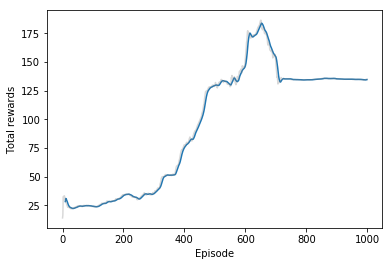

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

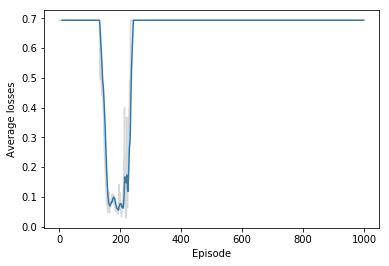

In [48]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [49]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.